In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import seaborn as sns
import pickle

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
traitlist = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/phenotype/20220822/traits.txt',sep=' ')
traitlist = list(traitlist.columns)[1:]

In [5]:
## read gtf data
df_gtf = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Genome_annotation/20220706/Danio_rerio.GRCz11.106.gtf',skiprows=5, delimiter='\t', header = None)

df_gtf = df_gtf.loc[~df_gtf[8].str.contains('gene_name "CU')]
import csv
df_gtf.to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Genome_annotation/20220706/Danio_rerio_protein_coding.GRCz11.106.gtf',
              index=False, header=False, sep='\t',doublequote=False, quoting = csv.QUOTE_NONE)

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
## read gff3 data
df_gff3 = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Genome_annotation/20220706/Danio_rerio.GRCz11.105.chr.gff3.gz',skiprows=32, delimiter='\t', header = None)
df_gff3=df_gff3.dropna()

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [20]:
def ld_block_construction(traits, ld_dir, mlma_dir_updated, r2_high, r2_low):
    
    """
    this function is to build a dataset of information of LD blocks for each trait and it takes four arguments
    1). the traits argument is a list of trait names. e.g. ['Latency_to_1st_dark_zone_entry']
    2). the ld_dir argument is the directory where all the ld related data generated from wynton is stored. 
    e.g. '/Users/jialexu/Library/CloudStorage/Box-Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20220310/'
    3). the mlma_dir argument is the directory where all the mlma files are stored
    e.g. '/Users/jialexu/Library/CloudStorage/Box-Box/UCSF/Research/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MLMA/20220103/'
    4). the r2 argument is the linkage disequilibrium threshold to define the LD block
    """
    def genes_in_block(snp, left, right):
        start = min(int(snp.split(':')[1]),left)
        end = max(int(snp.split(':')[1]),right)
        chr_num = snp.split(':')[0]
        df_gene = df_gff3.loc[df_gff3[0]== chr_num]
        df_gene = df_gene.loc[df_gene[2]=='gene']
        df_gene = df_gene.loc[(df_gene[4]>start)&(df_gene[3]<end)]
  
        return df_gene
    
    df_LD_block_single_trait_list = []
    for trait in traits:
        ### read all the needed data files for the current trait
        trait_no = str(traitlist.index(trait)+1)
        file1=ld_dir+trait+'_no_prune.r.ld'
        file2=ld_dir+trait+'_no_prune.snp.ld'
        file3=ld_dir+trait+'_no_prune.rsq.ld'
        if os.path.exists(file1):
            df1 = pd.read_csv(file1, header=None, index_col=False, sep='\t')
            df1 = df1[0].str.split(expand=True)
            df2 = pd.read_csv(file2, header=None, index_col=False, sep='\t')
            df2 = df2[0].str.split(expand=True)
            df3 = pd.read_csv(file3, header=0, index_col=0, sep='\t')
            df1.index = df3.index
            df2.index = df3.index
            trait_mlma = mlma_dir_updated+'Updated_Trait'+trait_no+'.mlma'
            df_trait_mlma = pd.read_csv(trait_mlma,header=0, index_col=False, sep='\t')[['-log10_P','SNP', 'A1', 'A2', 'Freq', 'b','se','p']]
            #df_trait_mlma.insert(0, '-log10_P', df_trait_mlma['p'].apply(lambda x: math.log(x, 10)*(-1)))
        
            ### reorganize the data file and make a dataset
            ld_block_dic = {}
            for snp in df3.index:
                print(snp)
                df_r2 = df1.loc[snp].astype('float32')**2
                df_nearby_snp = df2.loc[snp].str.split(":").str[1].dropna()
                df_snp_id = df2.loc[snp].dropna()
                chr_num = df2.loc[snp].str.split(":").str[0].dropna()
                df = pd.DataFrame({'SNP':df_snp_id,'pos':df_nearby_snp,'chr':chr_num,'r2':df_r2})
                df = df.set_index('SNP')
                df = df.dropna()
                df.loc[snp] = [snp.split(':')[1], snp.split(':')[0], 1]
                df_mlma = df_trait_mlma.loc[df_trait_mlma['SNP'].isin(df.index)]
                df_mlma = df_mlma.set_index('SNP')
                df = pd.concat([df, df_mlma[['-log10_P', 'A1', 'A2', 'Freq', 'b','se','p']]], axis=1)
                df['pos']=df['pos'].astype('int')
                peak_snp_log10P = df_trait_mlma.loc[df_trait_mlma['SNP'] == snp].iloc[0,0]
                
                left_high = df.loc[df['r2']>r2_high]['pos'].min()
                right_high = df.loc[df['r2']>r2_high]['pos'].max()
                df_genes_in_block_small = genes_in_block(snp, left_high, right_high)
                small_block_size = right_high-left_high
                
                left_low = df.loc[df['r2']>r2_low]['pos'].min()
                right_low = df.loc[df['r2']>r2_low]['pos'].max()
                df_genes_in_block_big = genes_in_block(snp, left_low, right_low)
                big_block_size = right_low-left_low
                
                ld_block_dic.update({snp:[df,peak_snp_log10P,df_genes_in_block_small, left_high, right_high, small_block_size, df_genes_in_block_big, left_low, right_low,big_block_size]})

            df_LD_block_single_trait = pd.DataFrame(ld_block_dic).transpose()
            df_LD_block_single_trait.columns = ['SNPs_nearby', 'peak_snp_log10P', 'genes_in_small_block','small_block_start', 'small_block_end','small_block_size', 'genes_in_big_block','big_block_start', 'big_block_end','big_block_size']
            df_LD_block_single_trait['trait'] = trait
            df_LD_block_single_trait.index.names = ['Peak_SNP']
            df_LD_block_single_trait_list.append(df_LD_block_single_trait)
            
    return pd.concat(df_LD_block_single_trait_list)

In [21]:
df_ld_block_all = ld_block_construction(traitlist,
                     '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20230207/',
                     '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MLMA/20230203_ld_updated/', 0.6, 0.5)
##save the dataset of ld block generated above as a pickle 
import pickle
with open('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20230207/ld_block_info_20230207.pkl', 'wb') as outp:
    pickle.dump(df_ld_block_all, outp, pickle.HIGHEST_PROTOCOL)

2:44880680
5:3117060
14:46314911
17:33116150
1:52250293
13:1895832
14:11581401
17:13723952
5:12451112
5:66959339
2:48476767
5:3117060
13:1895832
5:12414530
1:53479201
5:45912699
2:34072988
2:34062563
20:14045887
3:52846402
15:9451741
2:8948407
4:27000825
14:13198899
17:13792560
14:11769426
14:11785249
14:12060890
14:14483142
14:11519756
14:12063284
14:11860985
5:66959339
20:28017927
6:9184432
14:51009177
6:9184432
14:51009177
20:4127543
17:36672970
1:13180420
3:40121382
11:28576523
23:4911792
20:44978164
8:17770038
13:1977303
20:14045887
25:17682572
5:66959339
13:46650132
17:36672970


## Make LD block plots

In [3]:
with open('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20230207/ld_block_info_20230207.pkl', 'rb') as f:
    df_ld_block = pickle.load(f)

In [118]:
peak_snp_info_list = {}
df_temp = df_ld_block.reset_index().drop_duplicates(subset = 'Peak_SNP').set_index('Peak_SNP')

for peak_snp in df_temp.index:
    peak_snp_info = df_temp.loc[peak_snp]['SNPs_nearby'].loc[peak_snp]
    peak_snp_info_list.update({peak_snp:peak_snp_info})
df_peak_snp_info = pd.DataFrame(peak_snp_info_list)

In [119]:
df_peak_snp_info = df_peak_snp_info.transpose()

In [128]:
def reformat_allele(a1,a2,freq):
    freq = str(round(freq,2))+'%'
    return a1+'/'+a2+' ('+str(freq)+')'
df_peak_snp_info['alleles'] = df_peak_snp_info.apply(lambda x: reformat_allele(x['A1'], x['A2'],x['Freq']),axis=1)


In [130]:
df_peak_snp_info.sort_values('chr')

pos chr   r2  -log10_P A1 A2      Freq         b        se  \
1:13180420   13180420   1  1.0  7.324105  A  G  0.239254   0.12118  0.022191   
1:52250293   52250293   1  1.0  6.534097  T  A  0.185585 -0.133627  0.026057   
1:53479201   53479201   1  1.0  8.864031  T  C  0.112306 -0.204688  0.033781   
11:28576523  28576523  11  1.0  7.201904  A  T  0.324356 -0.120995  0.022363   
13:46650132  46650132  13  1.0  7.823723  T  A  0.013242 -0.462858  0.081755   
13:1977303    1977303  13  1.0  7.822888  A  G  0.165329  0.170312  0.030084   
13:1895832    1895832  13  1.0  6.641871  C  T  0.238713  0.134411  0.025974   
14:51009177  51009177  14  1.0  8.166267  G  C  0.134233 -0.171533  0.029599   
14:11860985  11860985  14  1.0  1.535692  G  T  0.097385  0.066627  0.030538   
14:12063284  12063284  14  1.0  1.222325  C  G  0.079554  0.059878  0.031828   
14:11519756  11519756  14  1.0  3.279077  T  C  0.187089   0.08029  0.023157   
14:14483142  14483142  14  1.0  3.557916  A  G  0.170172  0.084716  0.023298   
14:12060890  12060890  14  1.0  3.832308  G  T  0.165691  0.092294  0.024314   
14:11785249  11785249  14  1.0  2.938687  T  C   0.19541  0.073402  0.022581   
14:11769426  11769426  14  1.0  7.416851  G  T  0.177579  0.128975  0.023456   
14:13198899  13198899  14  1.0  7.111034  G  A  0.095661 -0.183835  0.034215   
14:46314911  46314911  14  1.0  7.098702  G  A  0.155635  0.150851  0.028103   
14:11581401  11581401  14  1.0  6.922247  A  G  0.143235  0.156745  0.029607   
15:9451741    9451741  15  1.0  6.720313  A  G  0.051345 -0.243379  0.046727   
17:13723952  13723952  17  1.0  7.744264  G  A  0.140044  0.163338  0.029012   
17:33116150  33116150  17  1.0  8.405952  A  T  0.385759  0.126543  0.021494   
17:36672970  36672970  17  1.0  9.250213  A  G  0.422993  0.130564  0.021056   
17:13792560  13792560  17  1.0  7.239813  T  C  0.125754  0.137687  0.025375   
2:34062563   34062563   2  1.0  9.403263  C  A  0.221969   0.16054  0.025662   
2:48476767   48476767   2  1.0  8.054529  A  G  0.068563 -0.235815  0.040997   
2:44880680   44880680   2  1.0  6.893721  G  A  0.198669  0.150897  0.028568   
2:34072988   34072988   2  1.0  9.095406  C  A  0.220288  0.157306  0.025602   
2:8948407     8948407   2  1.0  7.276634  T  C  0.036708 -0.289373  0.053181   
20:14045887  14045887  20  1.0  8.205878  T  A  0.144491  0.154545  0.026597   
20:44978164  44978164  20  1.0  6.856052  T  C  0.033034  0.258674   0.04912   
20:28017927  28017927  20  1.0  7.265921  G  A  0.299782 -0.121246  0.022301   
20:4127543    4127543  20  1.0  7.013014  T  A  0.098048 -0.185291   0.03475   
23:4911792    4911792  23  1.0  7.375756  T  A  0.090476 -0.189718  0.034609   
25:17682572  17682572  25  1.0  7.840911  G  A  0.051254 -0.228543   0.04032   
3:52846402   52846402   3  1.0  7.060117  C  T  0.060681 -0.227331  0.042477   
3:40121382   40121382   3  1.0   7.50785  G  C  0.346084  0.129355  0.023369   
4:27000825   27000825   4  1.0  6.763858  T  A  0.019956 -0.336807  0.064436   
5:12451112   12451112   5  1.0  8.695643  G  T  0.221908   0.15282  0.025485   
5:66959339   66959339   5  1.0  8.158322  G  C  0.128785    0.1864  0.032181   
5:3117060     3117060   5  1.0   7.22189  A  G  0.255197  0.133457  0.024629   
5:12414530   12414530   5  1.0  7.160504  G  A  0.233765 -0.135893  0.025196   
5:45912699   45912699   5  1.0  6.900029  C  T  0.473003 -0.115834  0.021919   
6:9184432     9184432   6  1.0  6.797087  A  C   0.10952  0.189748  0.036203   
8:17770038   17770038   8  1.0   7.58219  A  T  0.017298  0.385668  0.069299   

                    p      alleles  
1:13180420        0.0  A/G (0.24%)  
1:52250293        0.0  T/A (0.19%)  
1:53479201        0.0  T/C (0.11%)  
11:28576523       0.0  A/T (0.32%)  
13:46650132       0.0  T/A (0.01%)  
13:1977303        0.0  A/G (0.17%)  
13:1895832        0.0  C/T (0.24%)  
14:51009177       0.0  G/C (0.13%)  
14:11860985  0.029128   G/T (0.1%)  
14:12063284  0.059934  C/G (0.08%)  
14:1151975

In [22]:
import pickle
with open('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20230207/ld_block_info_20230207.pkl', 'rb') as f:
    df_ld_block = pickle.load(f)
df_ld_block = df_ld_block.loc[df_ld_block['peak_snp_log10P']>6.81]
df_ld_block['Chr'] = df_ld_block.index.str.split(":").str[0]
df_ld_block['Pos'] = df_ld_block.index.str.split(":").str[1]

dic = {'DET':'TDEN', 'DEAD':'ADED', 'LTFDE':'LFDE', 'DZTD':'TDDZ'}
def trait_convert(convert_map, trait):
    if '_' in trait and trait.split('_')[1] in list(convert_map.keys()):
        return trait.replace(trait.split('_')[1], convert_map[trait.split('_')[1]])
    elif trait in list(convert_map.keys()):
        return convert_map[trait] 
    else:
        return trait
df_ld_block['trait'] = df_ld_block['trait'].apply(lambda x: trait_convert(dic, x))


In [54]:
snp_no_list=[]
for i in range (len(df_ld_block.index)):
    snp_no = ((df_ld_block.iloc[i,0]['-log10_P']>=6.81)&
               (df_ld_block.iloc[i,0]['pos']>=df_ld_block.iloc[i,3])&
              (df_ld_block.iloc[i,0]['pos']<=df_ld_block.iloc[i,4])).value_counts().iloc[1]
    snp_no_list.append(snp_no)
df_ld_block['No. of_sig_SNP'] = snp_no_list

In [59]:
df_output = df_ld_block[['Chr', 'Pos', 'peak_snp_log10P', 'small_block_start', 'small_block_end','small_block_size', 'trait', 'No. of_sig_SNP']]
df_output.to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20230207/ld_block_info_20230207.csv')


In [24]:
#develop a function to plot the SNPs withint the LD block
#input is SNP ID (e.g. "16:23238763") and the dictionary of LD
def Draw_LD_Block(df_ld_block_all, snp, order, output_path):
    
    
    chr_num=snp.split(":")[0]
    
    if int(chr_num)<10:
        chr_num='0'+chr_num
    else:
        chr_num=chr_num
    chr_num='chr'+chr_num 
    
    df_LDblock=df_ld_block_all.iloc[order,:]['SNPs_nearby']
    peak_logP=df_ld_block_all.iloc[order,:]['peak_snp_log10P']
    trait = df_ld_block_all.iloc[order,:]['trait']
    peak_pos=int(snp.split(":")[1])
    
    if df_ld_block_all.iloc[order,:]['genes_in_small_block'].shape[0]>5:
        left=df_ld_block_all.iloc[order,:]['small_block_start']
        right=df_ld_block_all.iloc[order,:]['small_block_end']
        
    else:
        left=df_ld_block_all.iloc[order,:]['big_block_start']
        right=df_ld_block_all.iloc[order,:]['big_block_end']
    
    interval = max(abs(peak_pos-left), abs(peak_pos-right))
    
    df_LDblock=df_LDblock.loc[(df_LDblock['pos']>(min(left, peak_pos)*0.9))&(df_LDblock['pos']<(max(right, peak_pos)*1.1))]
    
    df_plot=df_ld_block_all.iloc[order,:]['SNPs_nearby']
    
    df_plot_g2=df_plot.loc[(df_plot['r2']>0.6)&(df_plot['r2']<0.8)]
    df_plot_g3=df_plot.loc[(df_plot['r2']>0.4)&(df_plot['r2']<0.6)]
    df_plot_g4=df_plot.loc[(df_plot['r2']>0.2)&(df_plot['r2']<0.4)]
    df_plot_g5=df_plot.loc[(df_plot['r2']<0.2)]
    df_plot_g1=df_plot.loc[df_plot['r2']>0.8]
    f = plt.figure(figsize=(15,10))
    color_platte = ['#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#ff0000']
    #color_platte = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#ff0000']
    plt.scatter(df_plot_g5['pos']/1000000, df_plot_g5['-log10_P'], c=color_platte[0], label='0.2')
    plt.scatter(df_plot_g4['pos']/1000000, df_plot_g4['-log10_P'], c=color_platte[1], label='0.4')
    plt.scatter(df_plot_g3['pos']/1000000, df_plot_g3['-log10_P'], c=color_platte[2], label='0.6')
    plt.scatter(df_plot_g2['pos']/1000000, df_plot_g2['-log10_P'], c=color_platte[3], label='0.8')
    plt.scatter(df_plot_g1['pos']/1000000, df_plot_g1['-log10_P'], c=color_platte[4], label='1')
    plt.scatter(x=peak_pos/1000000, y=peak_logP, c=color_platte[5], label=' ', s=350, marker='D', edgecolor='grey')
    ax=plt.gca()
    plt.ylim(-0.5,10)
    if (min(left, peak_pos)-interval*0.2)>0:
        plt.xlim((min(left, peak_pos)-interval*0.2)/1000000, (max(right, peak_pos)+interval*0.2)/1000000)
    else:
        plt.xlim((min(left, peak_pos)-10000)/1000000, (max(right, peak_pos)+interval*0.2)/1000000)
    #plt.xlim((peak_pos-interval-10000)/1000000, (peak_pos+interval+10000)/1000000)
    #plt.ylabel(r'$-log_{10}P-value$', fontsize=25)
    plt.ylabel(r'$-log_{10}P$-value', style='italic', fontsize=30)
    plt.tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are on
                    top=False,         # ticks along the top edge are off
                    labelbottom=True,labelsize=22)
    plt.yticks(size=25)
    plt.axvline(x = (min(left, peak_pos)-1000)/1000000, c='#007f7f', linestyle = '-.', ymax = 0.8)
    plt.axvline(x = (max(right, peak_pos)+1000)/1000000, c='#007f7f', linestyle = '-.', ymax = 0.8)
    print('LD_block: %s:%i-%i'%(chr_num, (min(left, peak_pos)), max(right, peak_pos)))
    print('plot region: %s:%i-%i'%(chr_num, min(left, peak_pos)-interval*0.2, max(right, peak_pos)+interval*0.2))
    plt.title(trait,size=40)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(output_path+trait+'_LD_'+chr_num+'_'+str(peak_pos)+'_snp.tif',bbox_inches='tight')
    #plt.legend(loc="upper left", frameon=False, fontsize=15, ncol = 1)
    plt.show()
    #return f

LD_block: chr02:43410268-45154840
plot region: chr02:43116185-45448922


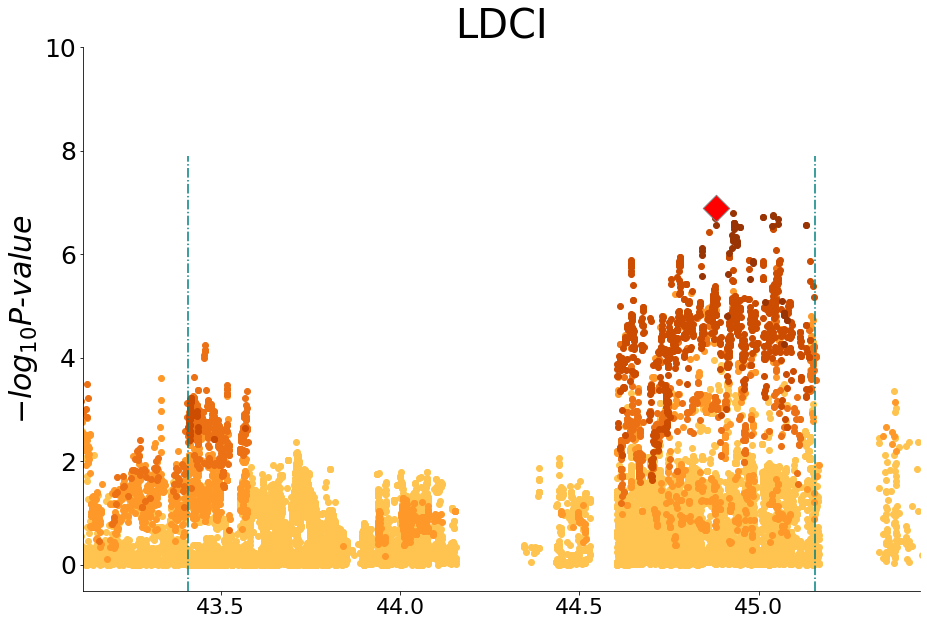

LD_block: chr05:3064373-3148905
plot region: chr05:3053835-3159442


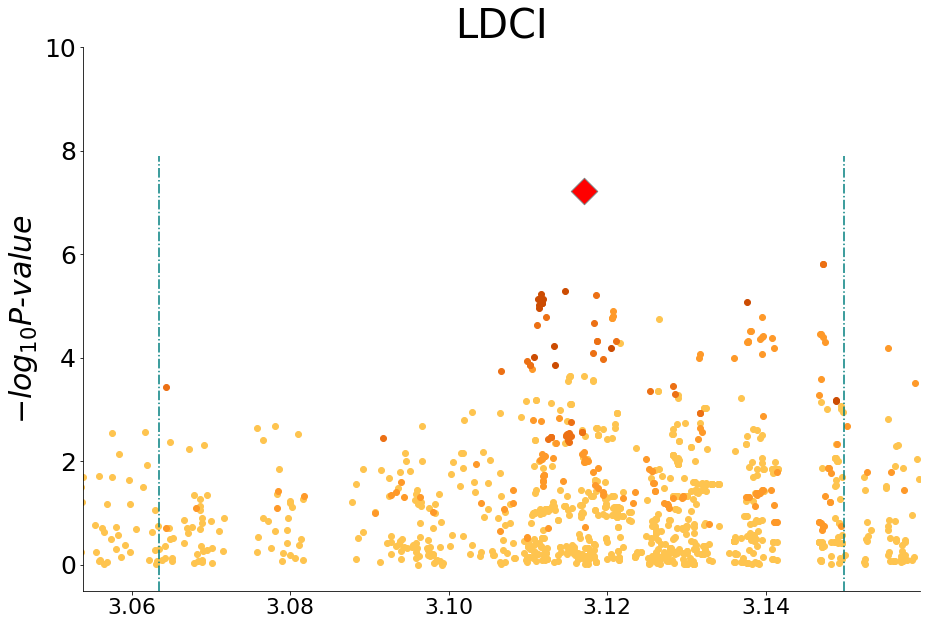

LD_block: chr14:46011001-46417125
plot region: chr14:45950219-46477907


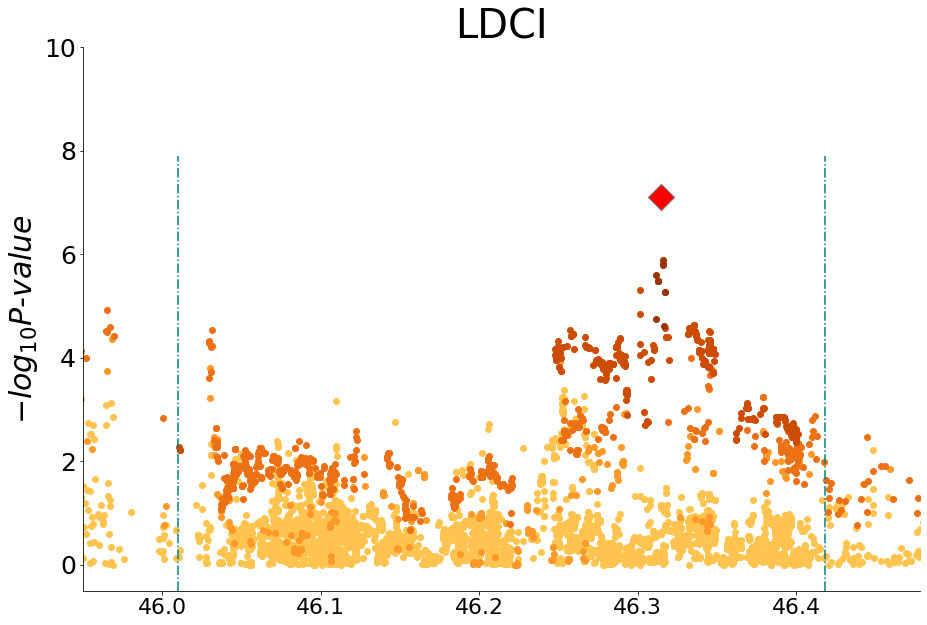

LD_block: chr17:32999930-33298589
plot region: chr17:32963442-33335076


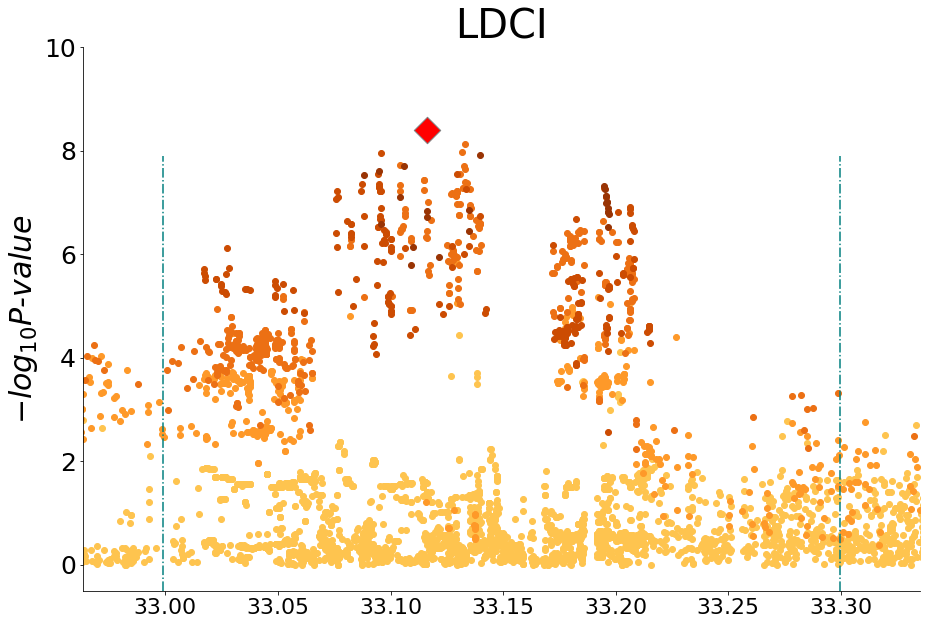

LD_block: chr14:11463826-13187985
plot region: chr14:11142509-13509301


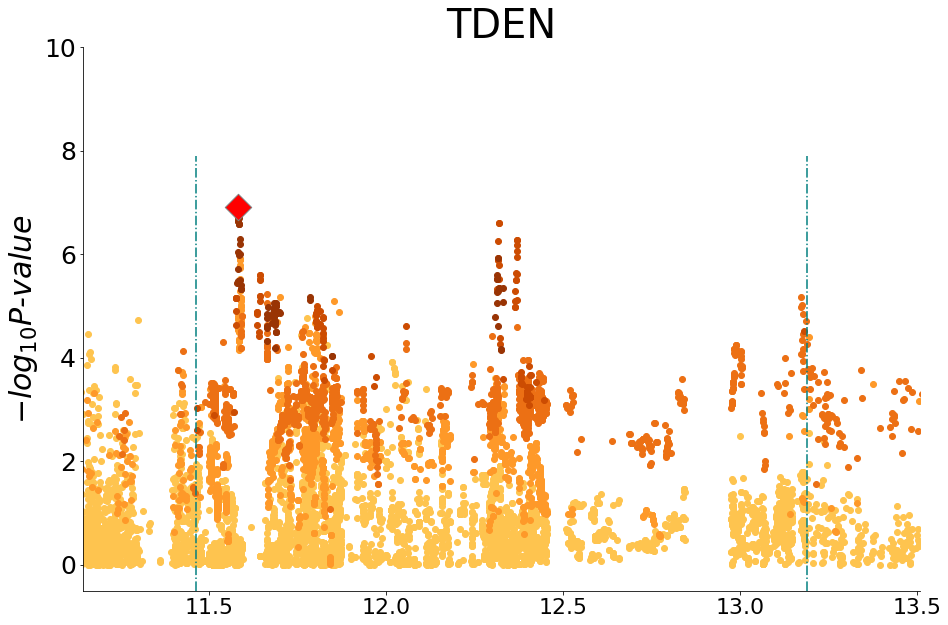

LD_block: chr17:13690862-14019630
plot region: chr17:13631726-14078765


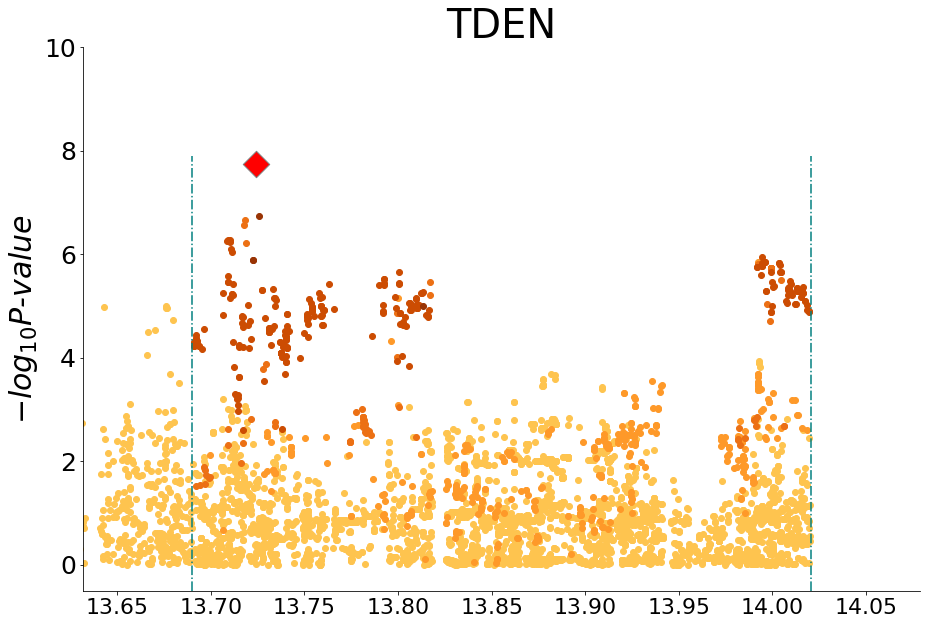

LD_block: chr05:12118947-13471630
plot region: chr05:11914843-13675733


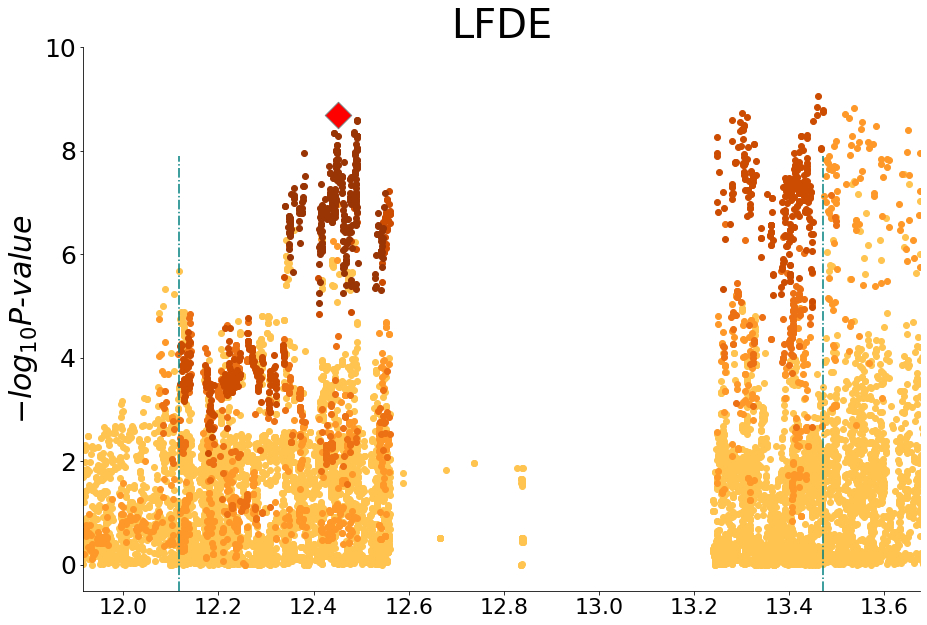

LD_block: chr05:66820226-67144845
plot region: chr05:66783124-67181946


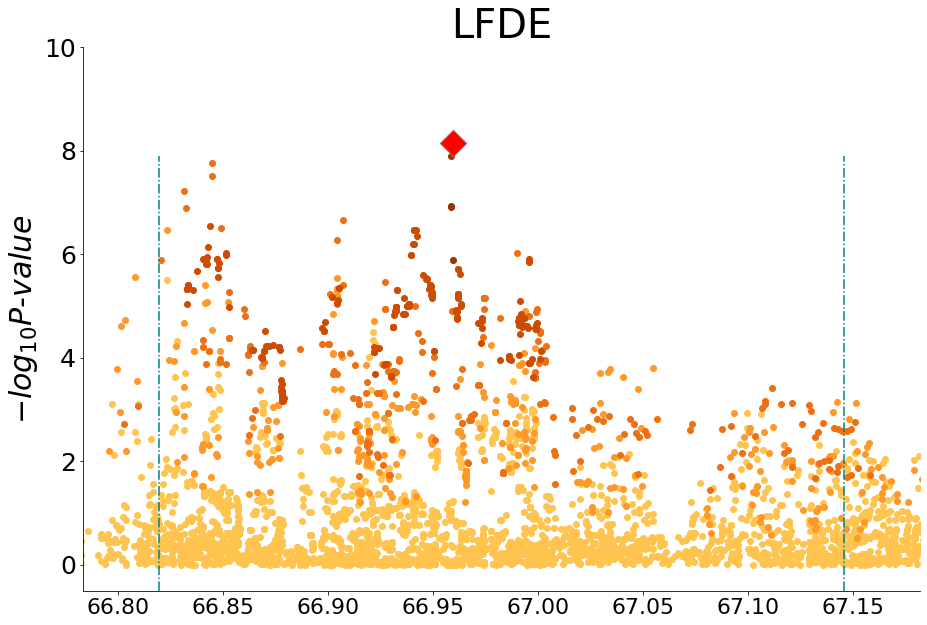

LD_block: chr02:48309970-48580988
plot region: chr02:48276610-48614347


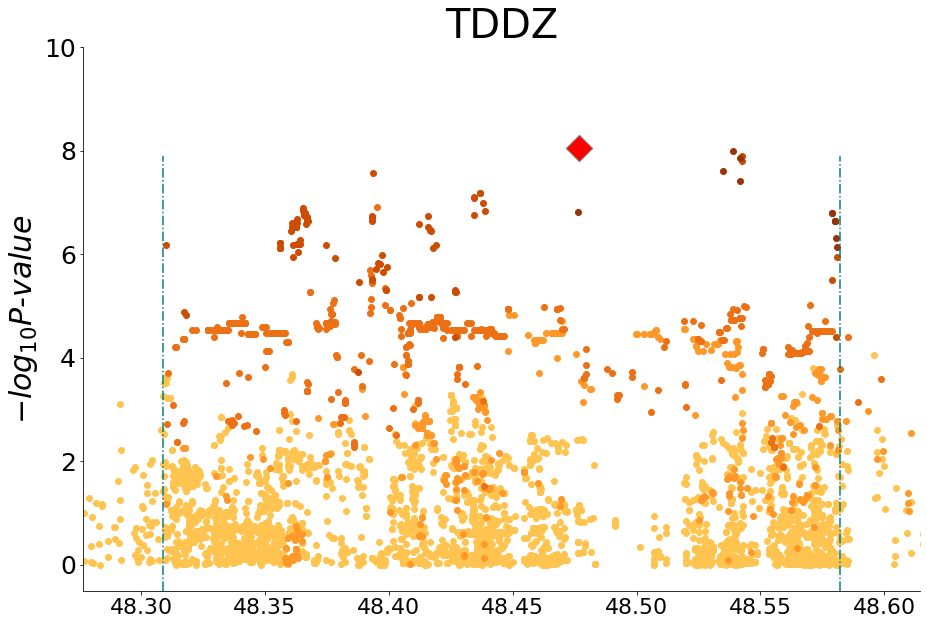

LD_block: chr05:3064373-3148905
plot region: chr05:3053835-3159442


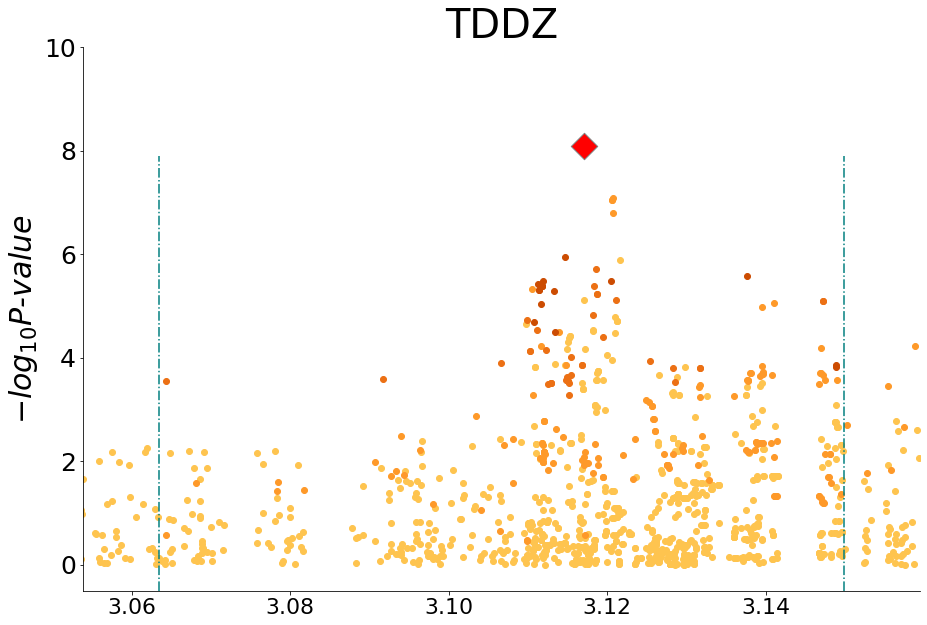

LD_block: chr13:1821356-1994794
plot region: chr13:1801563-2014586


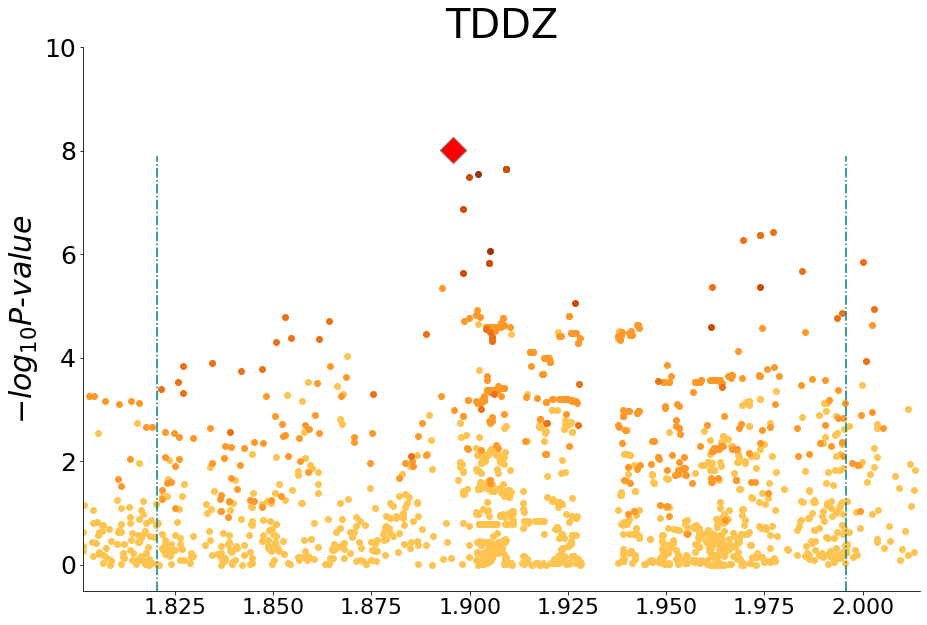

LD_block: chr05:12127539-13471630
plot region: chr05:11916119-13683050


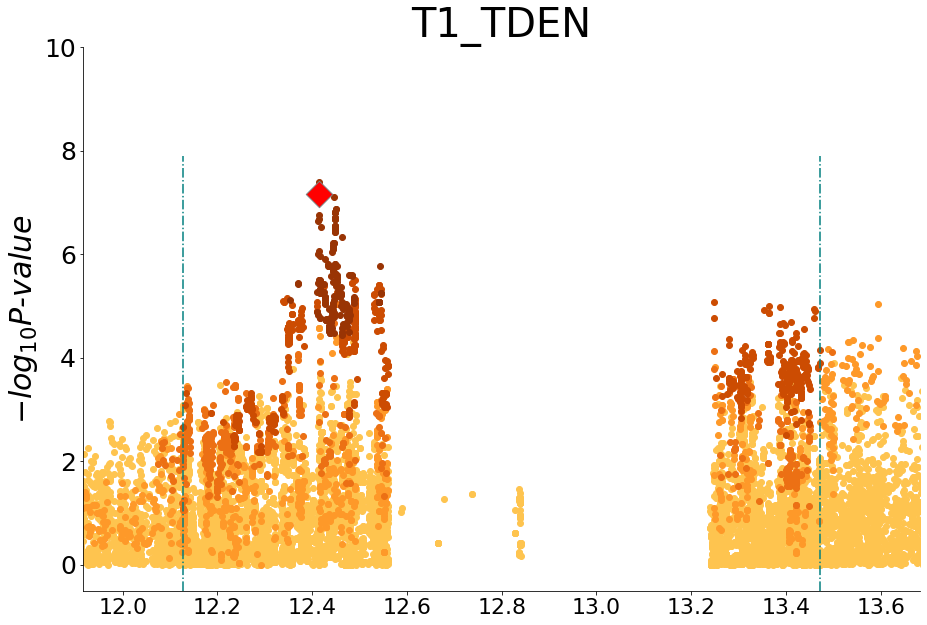

LD_block: chr01:53376636-53789539
plot region: chr01:53314568-53851606


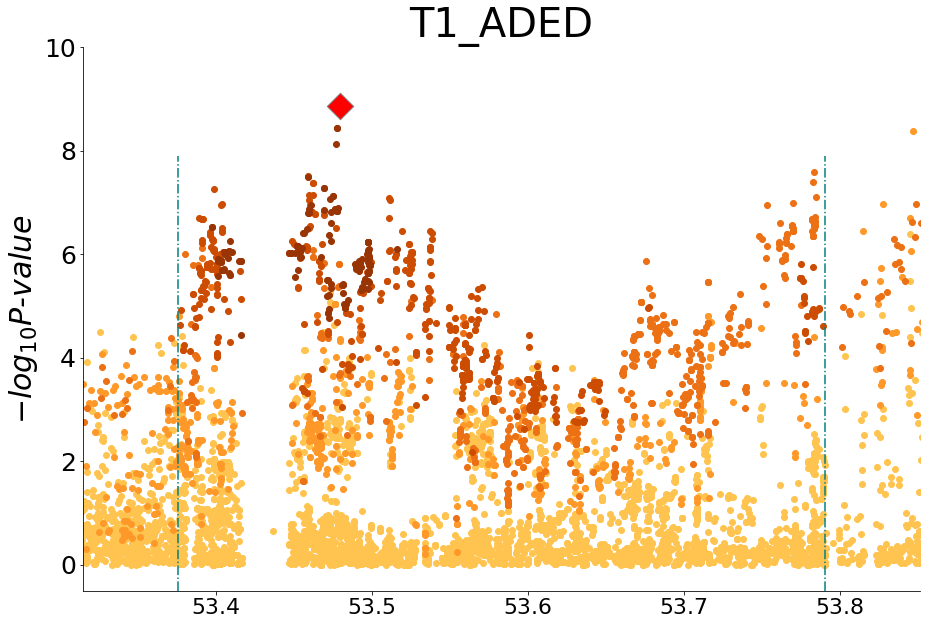

LD_block: chr05:45333677-48256655
plot region: chr05:44864885-48725446


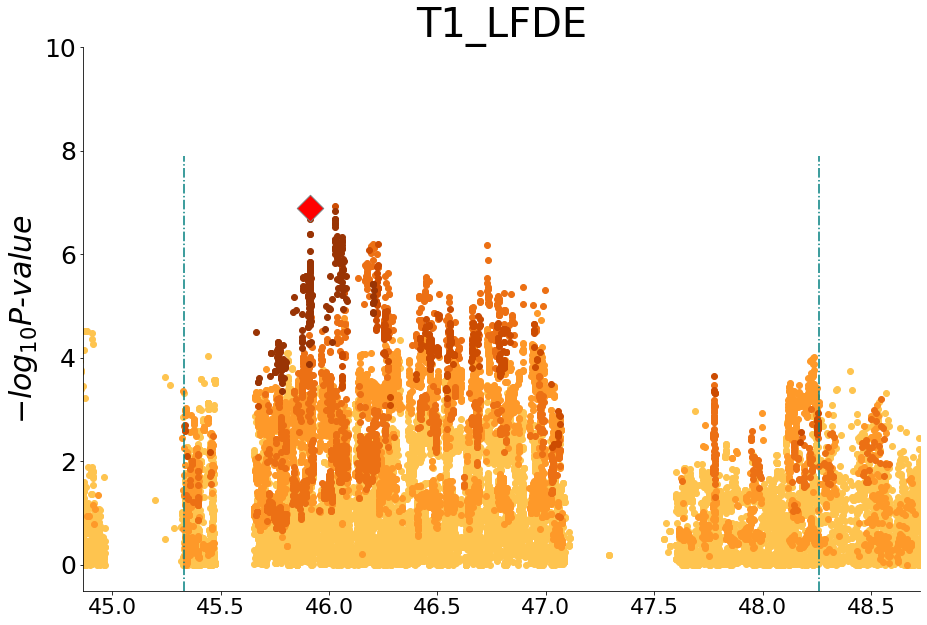

LD_block: chr02:33646066-34454726
plot region: chr02:33560681-34540110


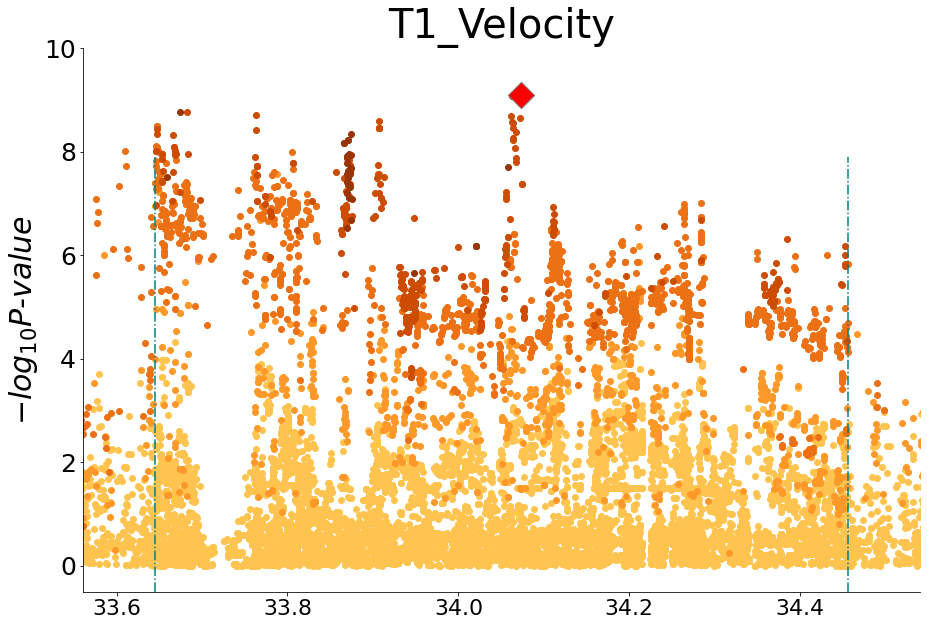

LD_block: chr02:33646066-34454726
plot region: chr02:33562766-34538025


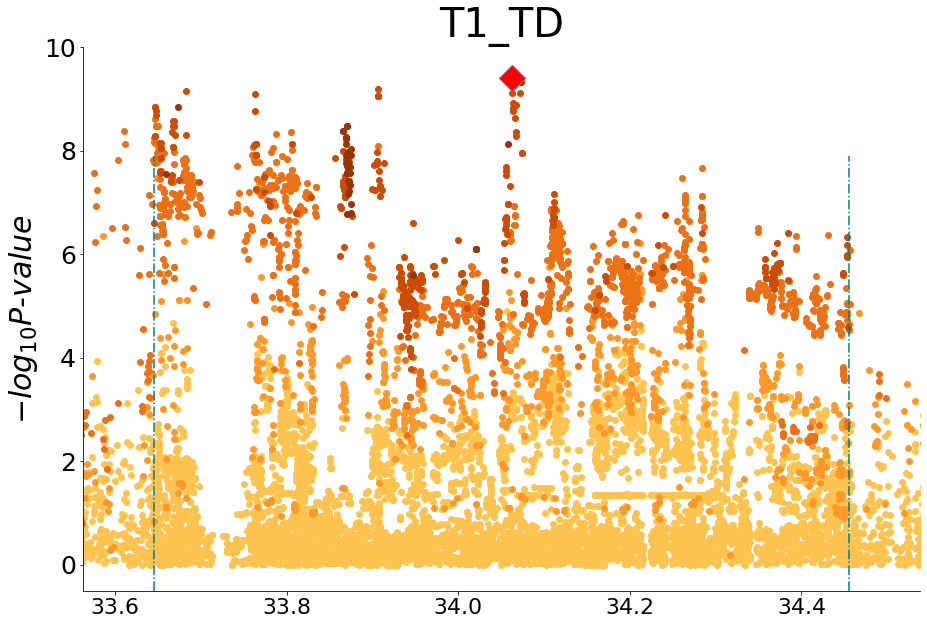

LD_block: chr20:13681243-15606526
plot region: chr20:13369115-15918653


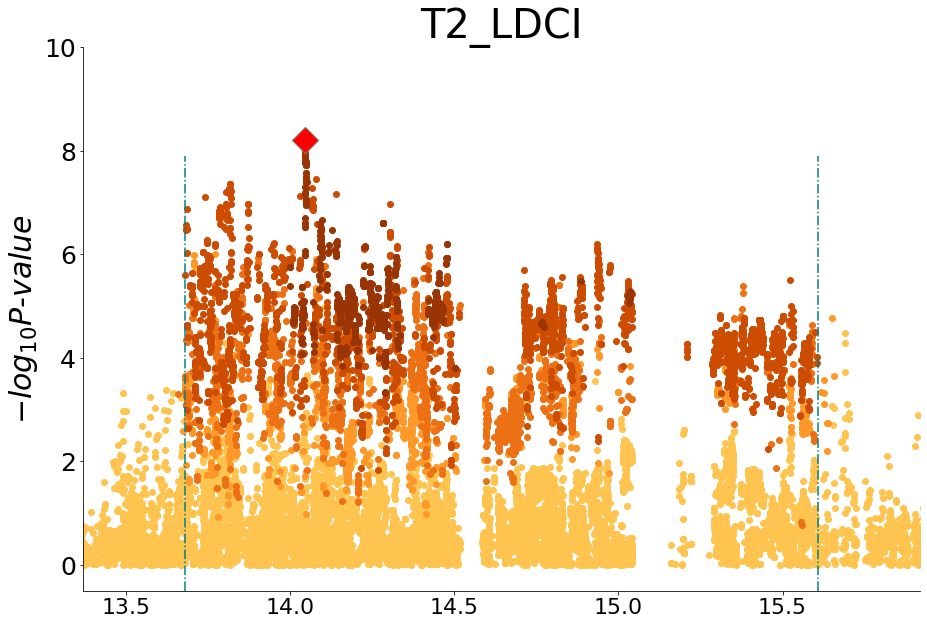

LD_block: chr03:52790918-52918033
plot region: chr03:52776591-52932359


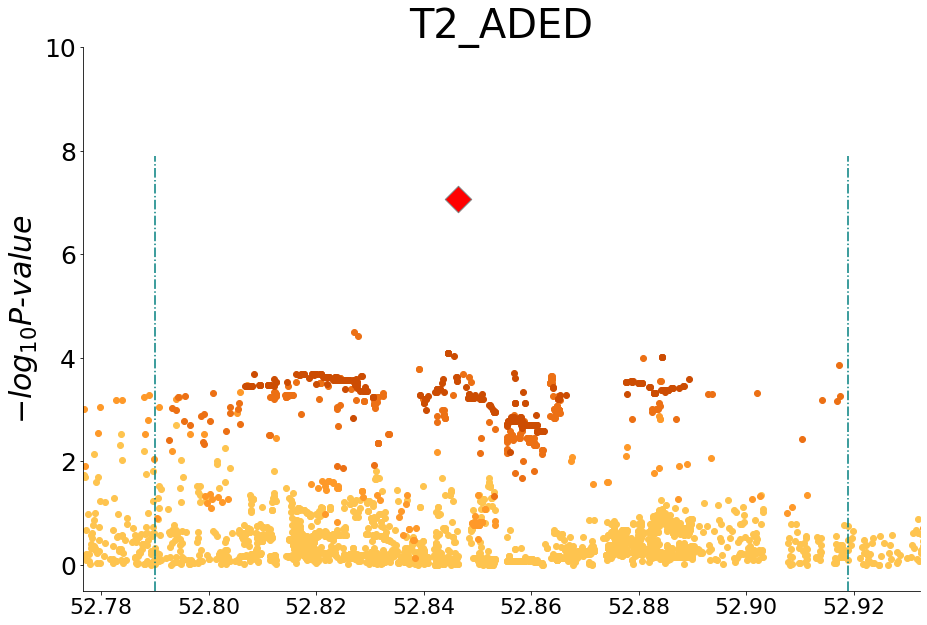

LD_block: chr02:8604134-8956209
plot region: chr02:8535279-9025063


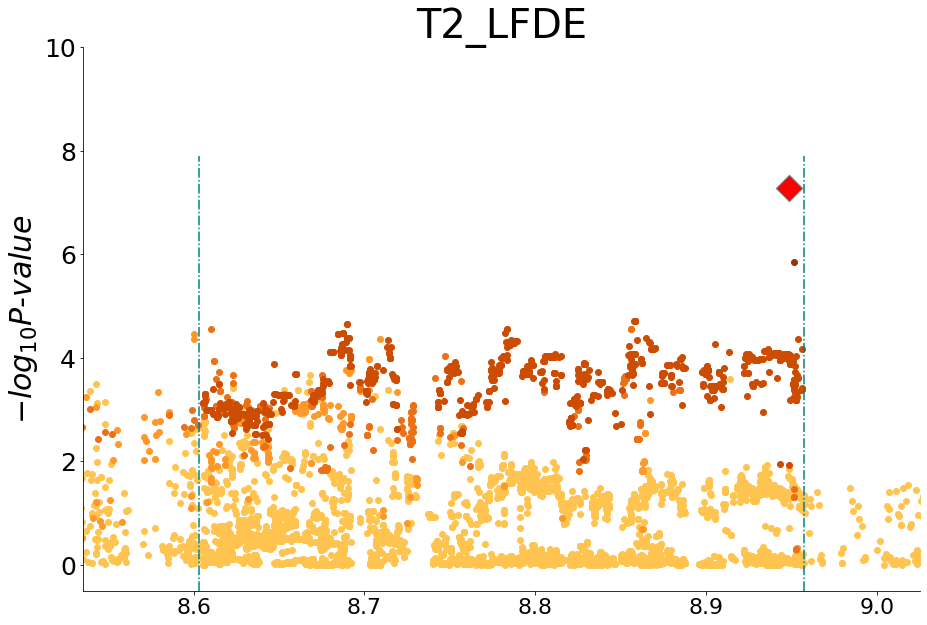

LD_block: chr14:11467285-14825707
plot region: chr14:11120962-15172029


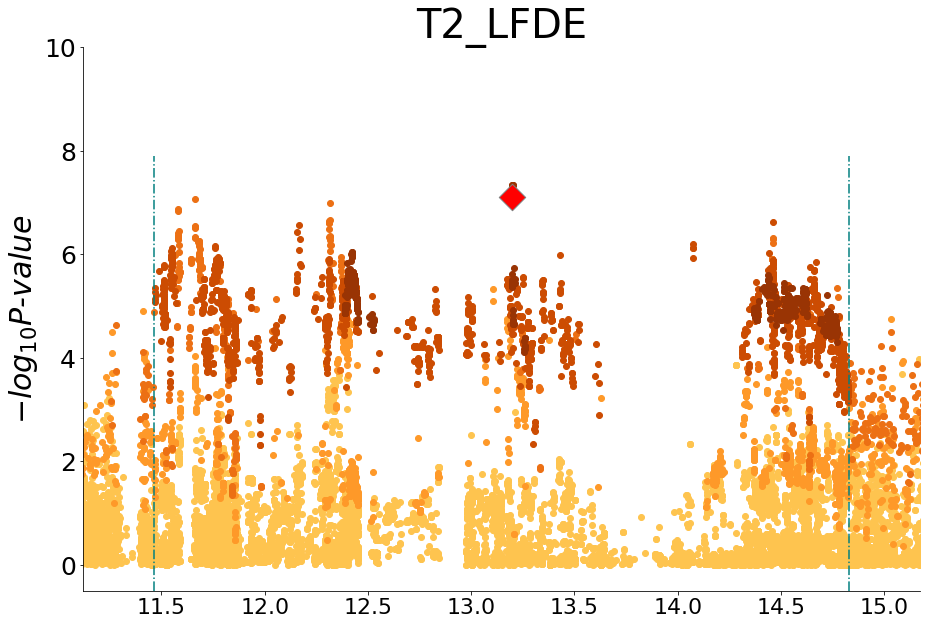

LD_block: chr17:13690862-14019630
plot region: chr17:13645448-14065044


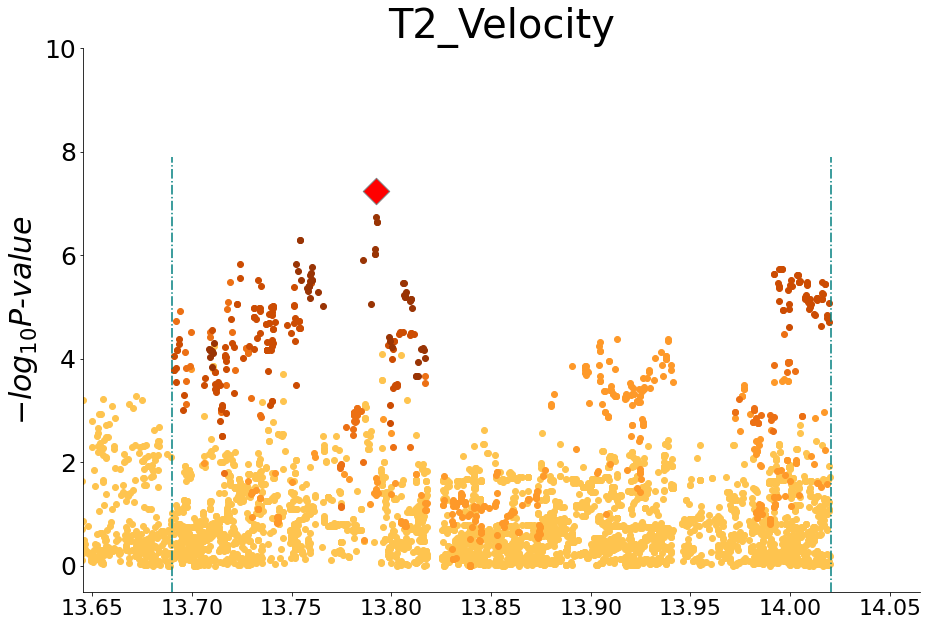

LD_block: chr14:11547351-14584147
plot region: chr14:10984406-15147091


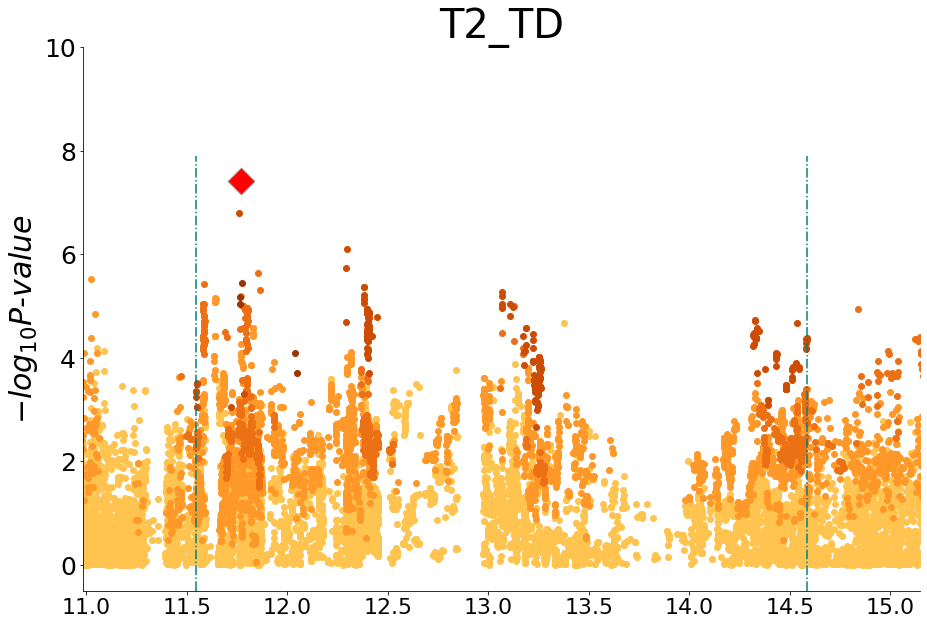

LD_block: chr05:66820226-67144845
plot region: chr05:66783124-67181946


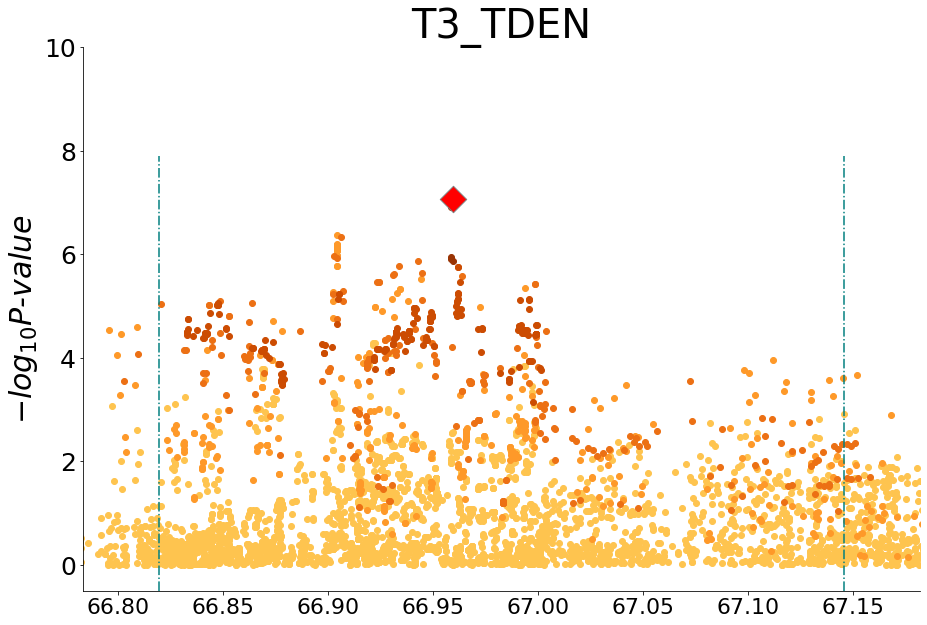

LD_block: chr20:27240341-28515033
plot region: chr20:27084823-28670550


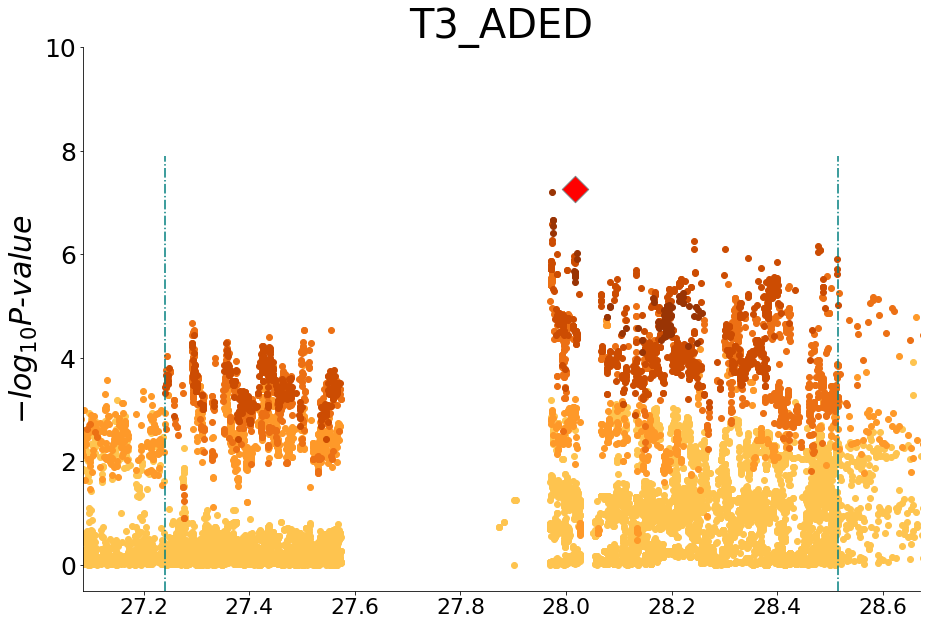

LD_block: chr14:50798800-51275308
plot region: chr14:50745573-51328534


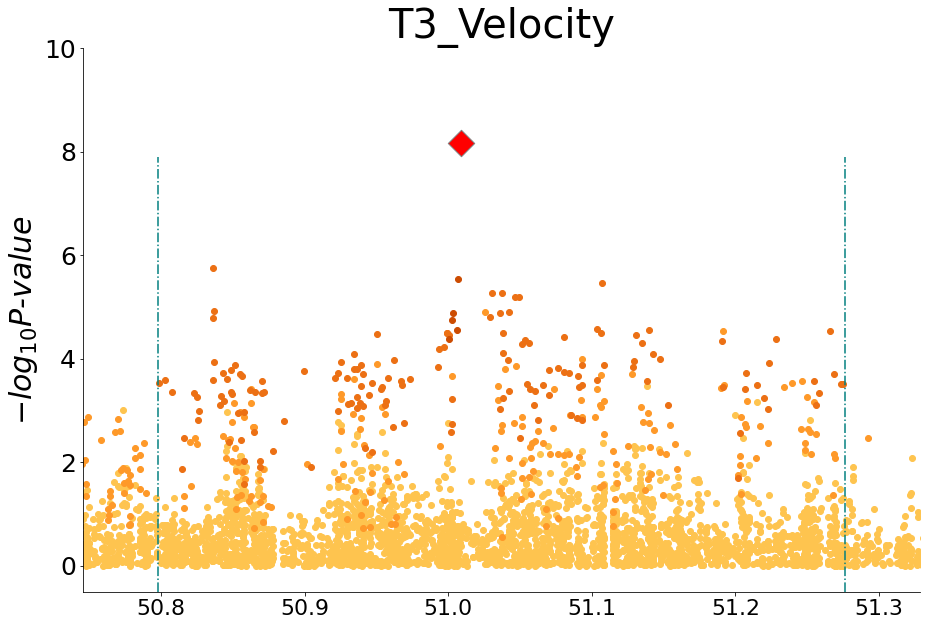

LD_block: chr14:50798800-51275308
plot region: chr14:50745573-51328534


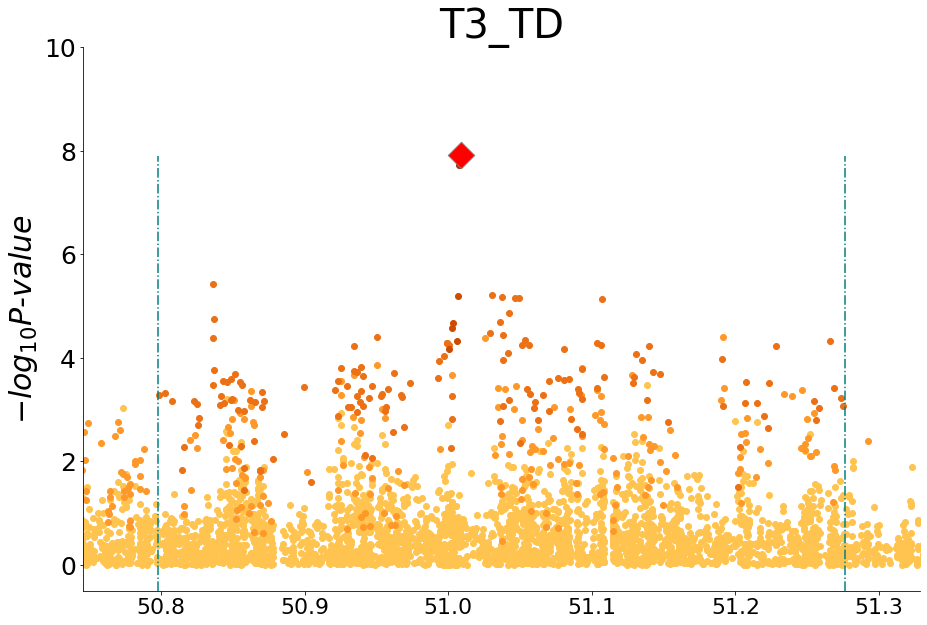

LD_block: chr20:3952155-4211592
plot region: chr20:3917077-4246669


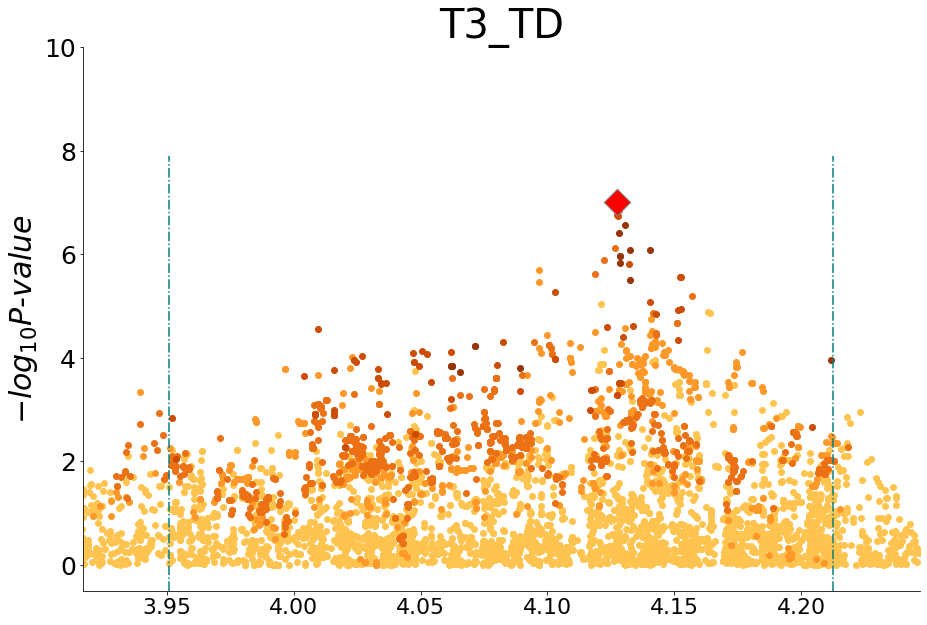

LD_block: chr17:36196042-36903822
plot region: chr17:36100656-36999207


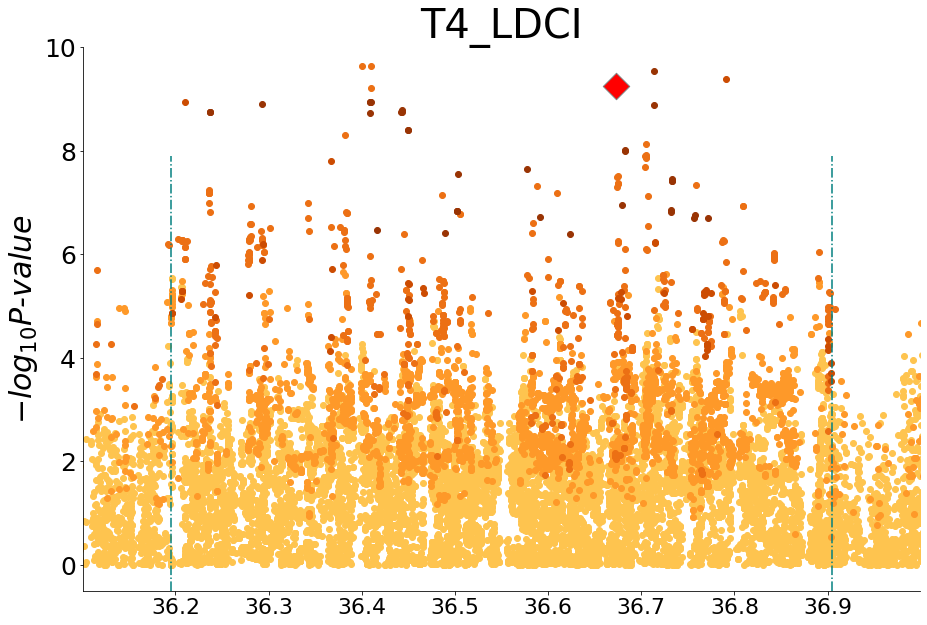

LD_block: chr01:11690229-13456076
plot region: chr01:11392190-13754114


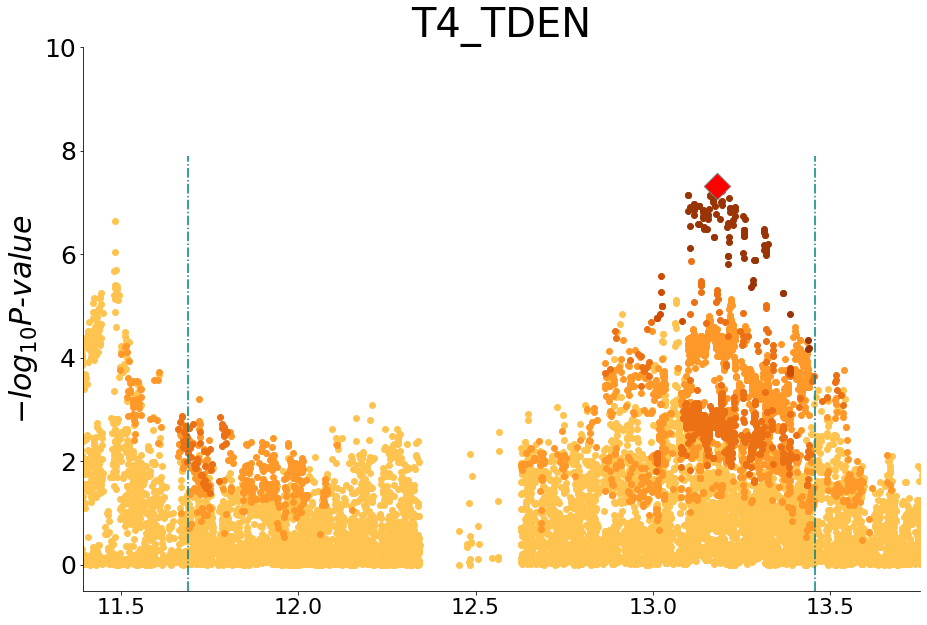

LD_block: chr03:40121331-40121382
plot region: chr03:40121320-40121392


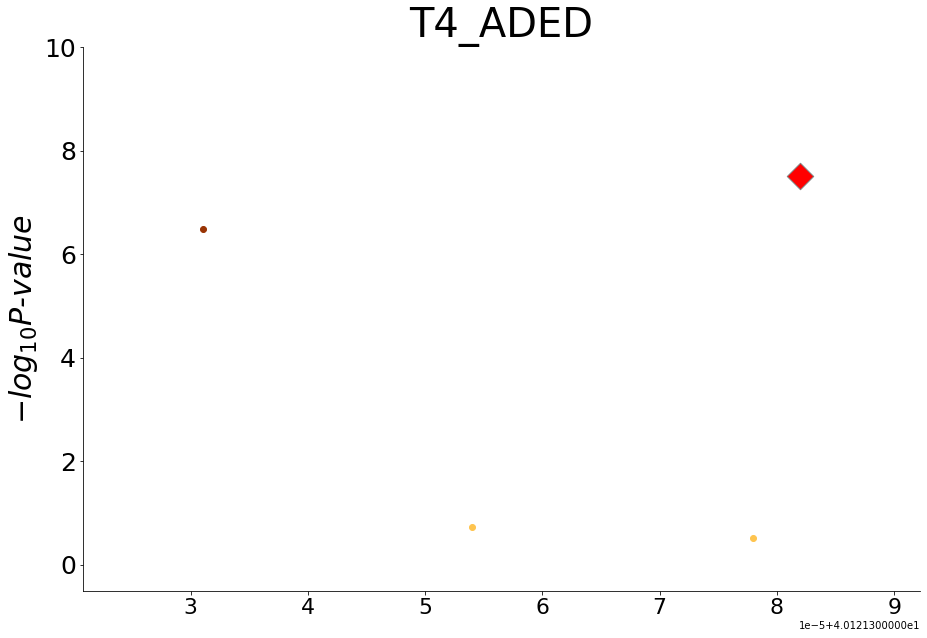

LD_block: chr11:24444893-29134593
plot region: chr11:23618567-29960919


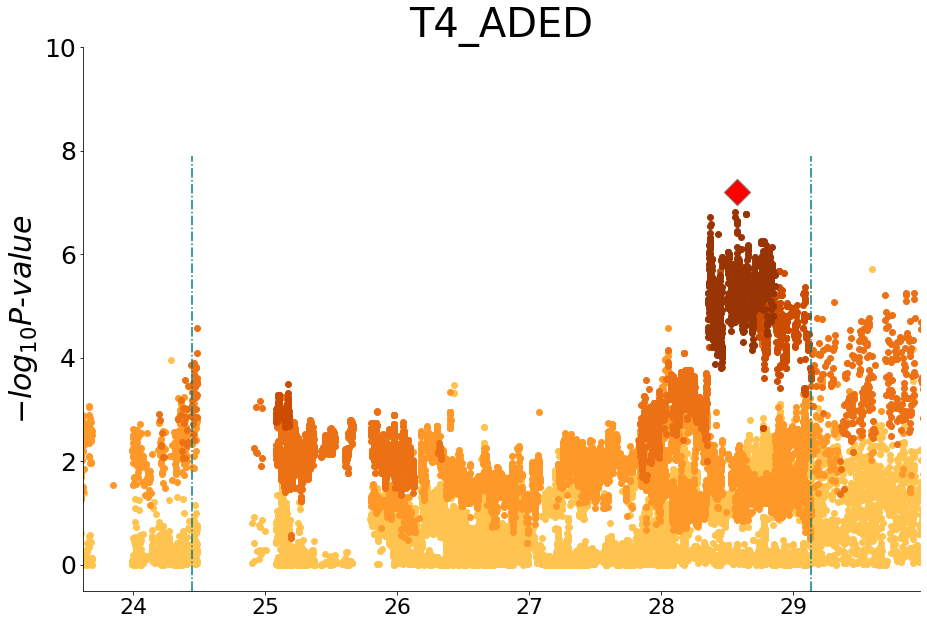

LD_block: chr23:4084863-4957204
plot region: chr23:3919477-5122589


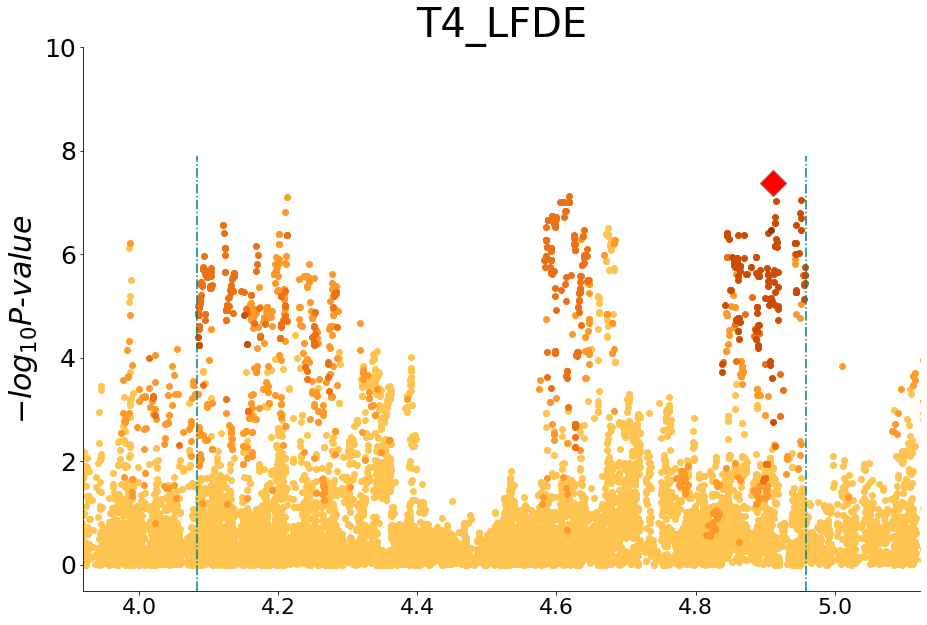

LD_block: chr20:44959183-45776340
plot region: chr20:44799547-45935975


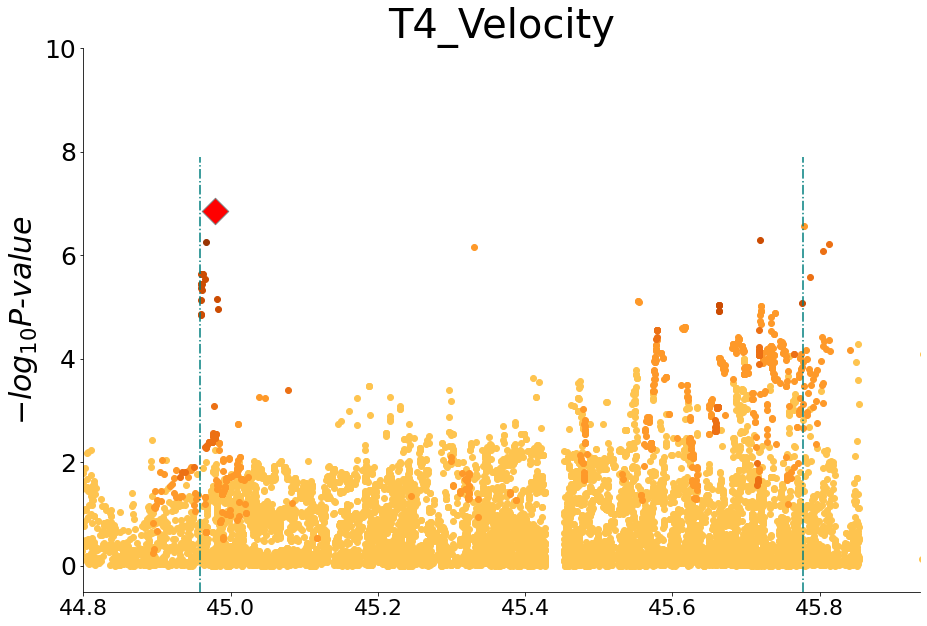

LD_block: chr08:16465036-18193036
plot region: chr08:16204035-18454036


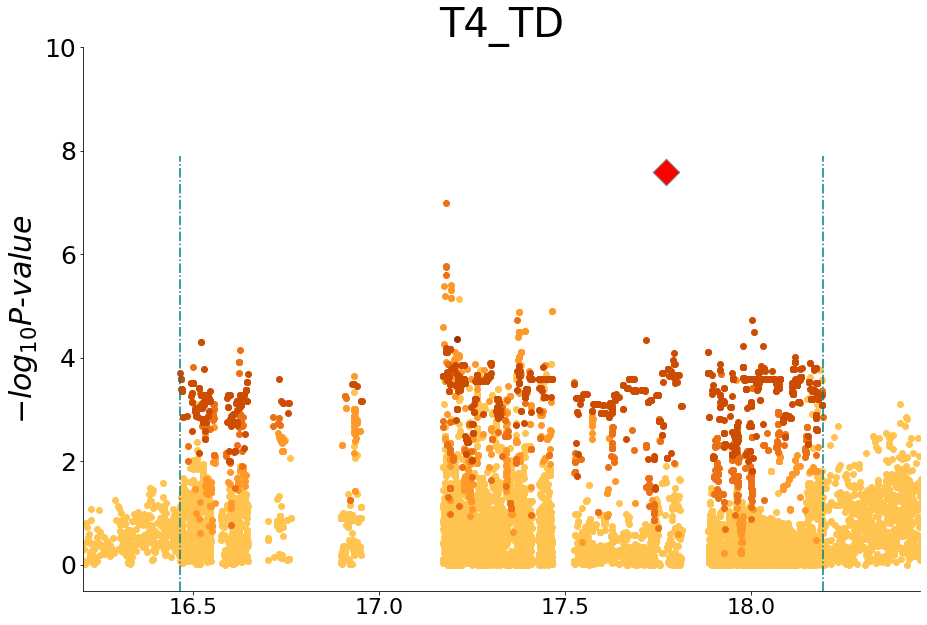

LD_block: chr13:1896493-2234760
plot region: chr13:1845001-2286251


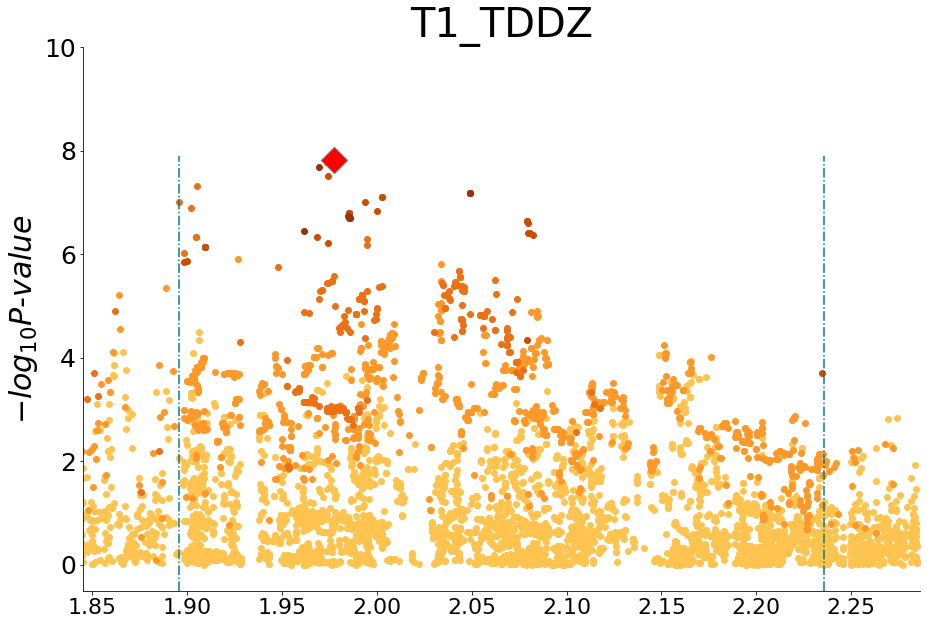

LD_block: chr20:13681243-15606526
plot region: chr20:13369115-15918653


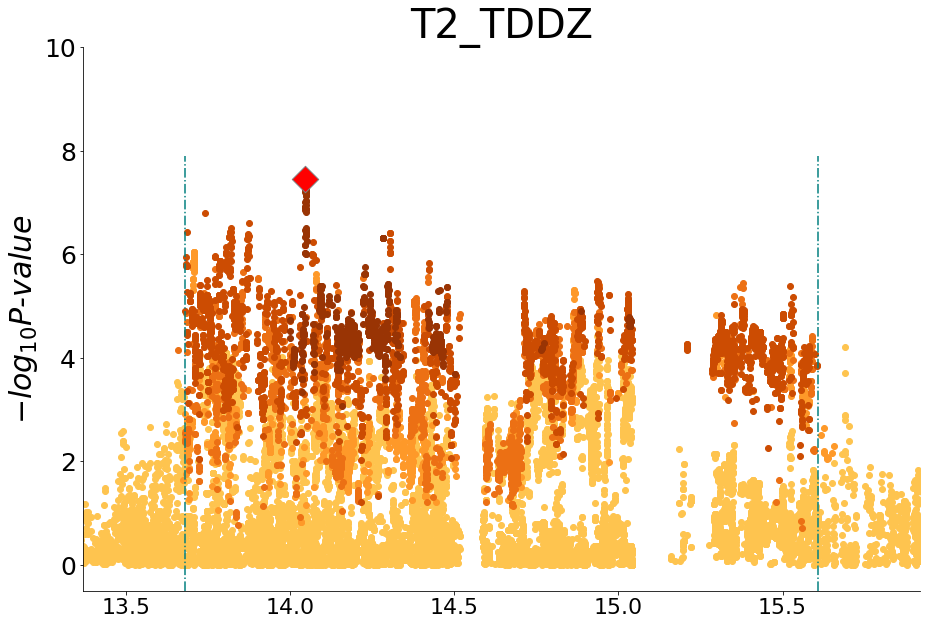

LD_block: chr25:17653244-17682598
plot region: chr25:17647378-17688463


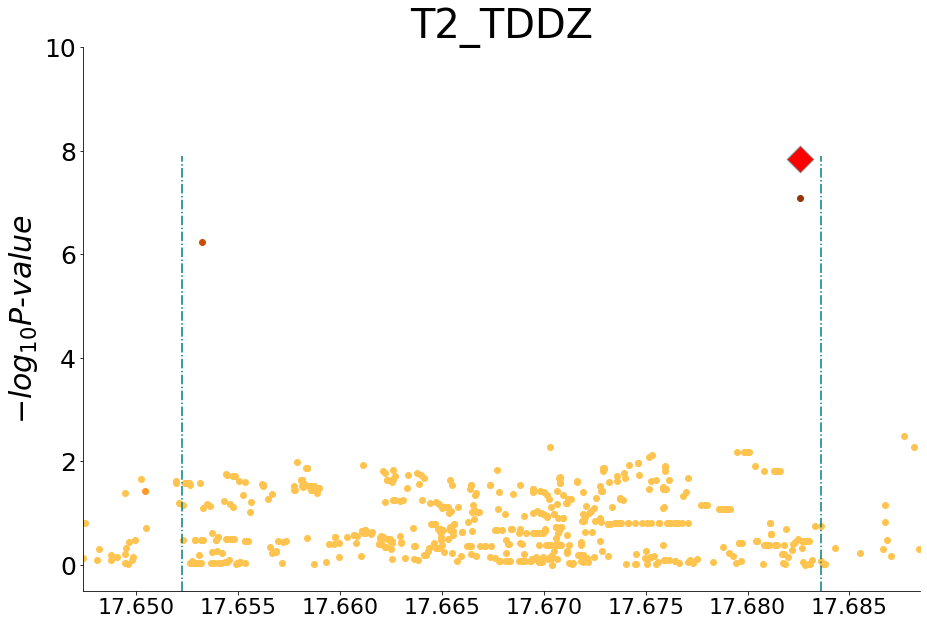

LD_block: chr05:66820226-67144845
plot region: chr05:66783124-67181946


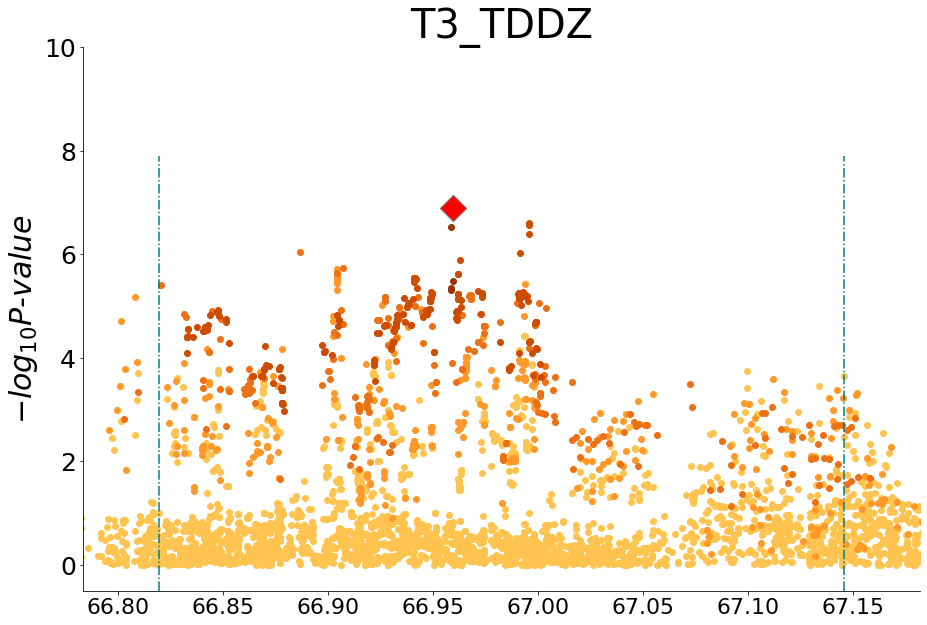

LD_block: chr13:46594400-46743542
plot region: chr13:46575718-46762224


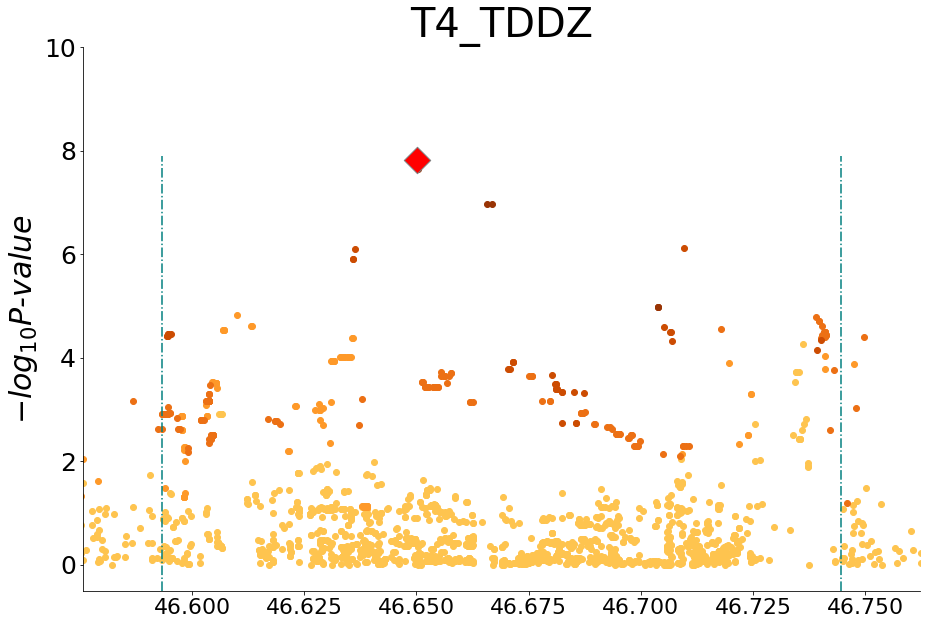

LD_block: chr17:36196042-36903822
plot region: chr17:36100656-36999207


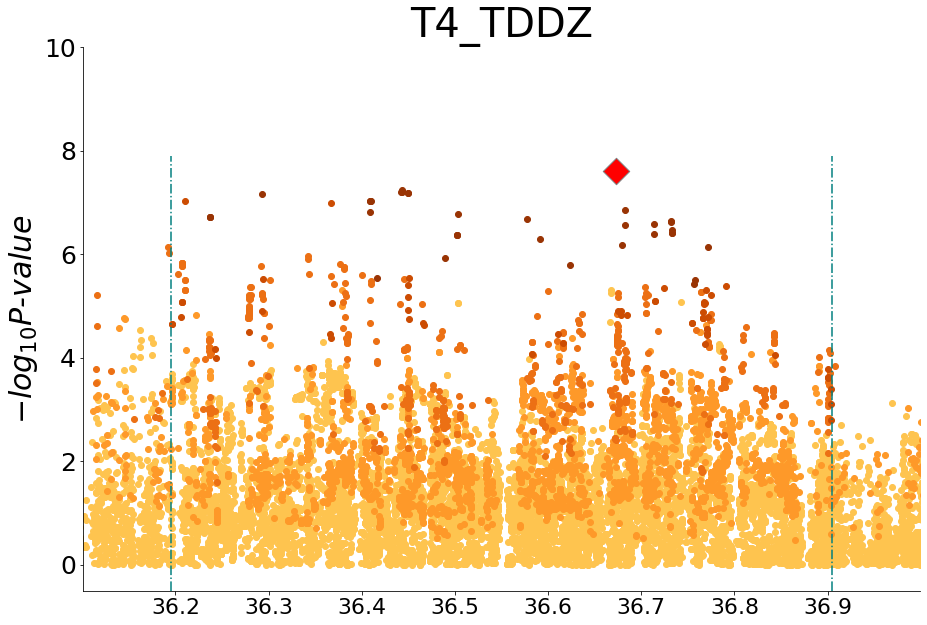

In [25]:
for i,snp in enumerate(df_ld_block.index):
    Draw_LD_Block(df_ld_block, snp, i, 
                  '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20230207/')


In [9]:
df_genes_in_block_list = []
for i in range(df_ld_block.shape[0]):
    snp = df_ld_block.index[i]
    trait = df_ld_block.iloc[i]['trait']
    small_block_genes = df_ld_block.iloc[i]['genes_in_small_block'][8].apply(lambda x: x.split(";")[1].split("=")[1]).unique()
    big_block_genes = df_ld_block.iloc[i]['genes_in_big_block'][8].apply(lambda x: x.split(";")[1].split("=")[1]).unique()
    peak_snp_log10P = df_ld_block.iloc[i,1]
    if len(small_block_genes) < 5 and len(big_block_genes) >len(small_block_genes):
        genes = big_block_genes
        r2 = 0.5
    else:
        genes = small_block_genes
        r2=0.6
    df_genes_in_block_list.append(pd.concat((pd.Series([snp]*len(genes)), 
                                             pd.Series([peak_snp_log10P]*len(genes)), 
                                             pd.Series(genes), 
                                             pd.Series([trait]*len(genes)), 
                                             pd.Series([r2]*len(genes))),axis=1)) 

df_genes_in_block = pd.concat(df_genes_in_block_list)   
df_genes_in_block.columns = ['Peak_snp', '-log10_P', 'Mapped_genes', 'Trait', 'r2']
df_genes_in_block = df_genes_in_block.set_index('Peak_snp')
df_genes_in_block.to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20220822/Candidate_gene_20220822.csv')


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dt

LD_block: chr02:43410268-45153038
plot region: chr02:43116185-45447120


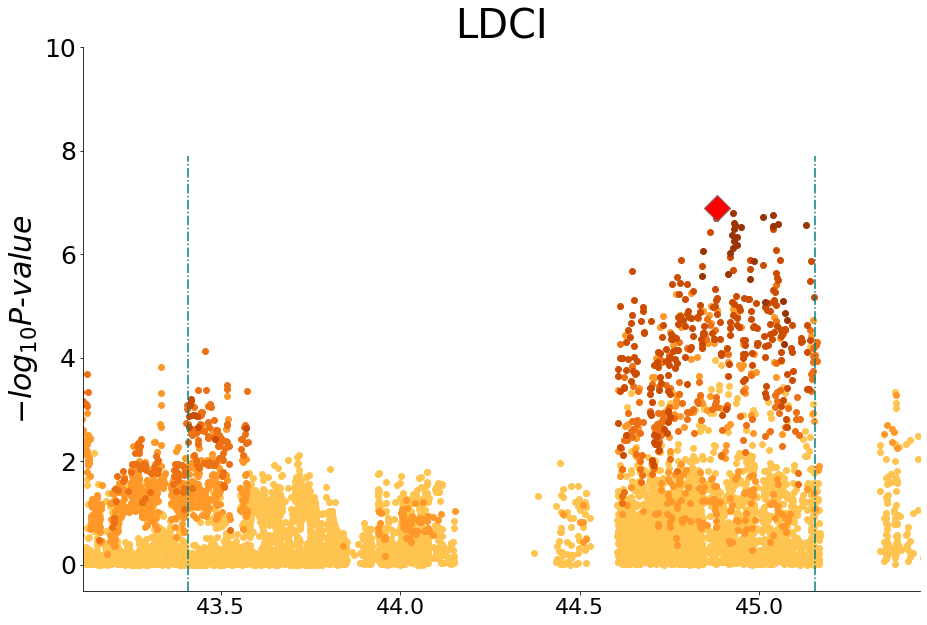

LD_block: chr05:3064373-3148858
plot region: chr05:3053835-3159395


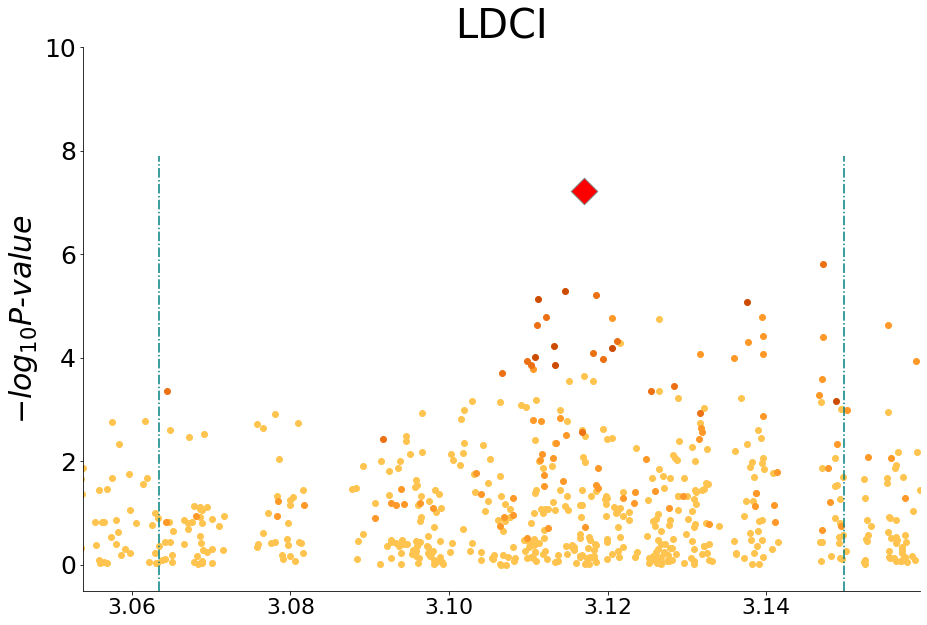

LD_block: chr14:46011134-46401191
plot region: chr14:45950378-46461946


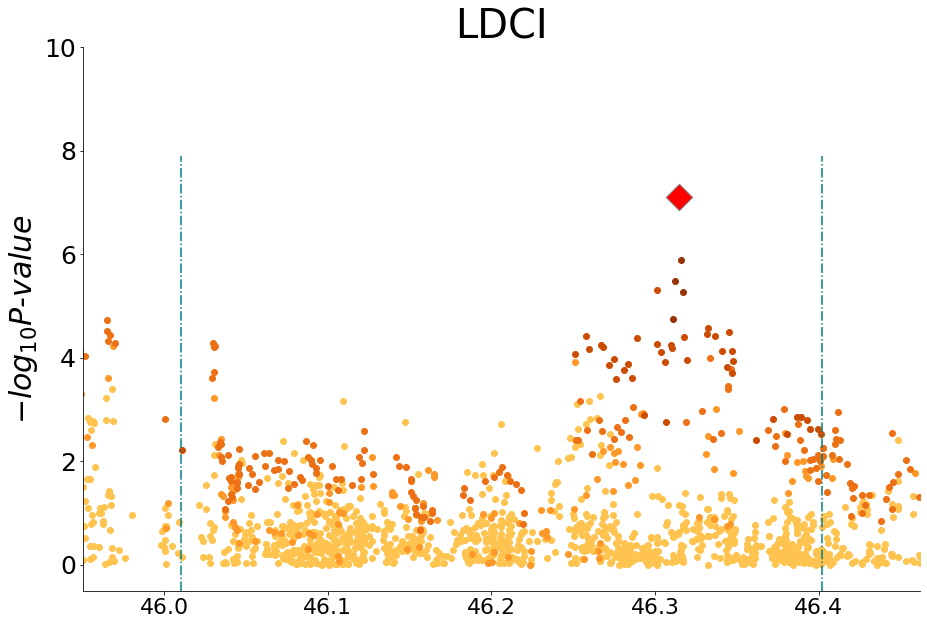

LD_block: chr17:33000605-33298510
plot region: chr17:32964133-33334982


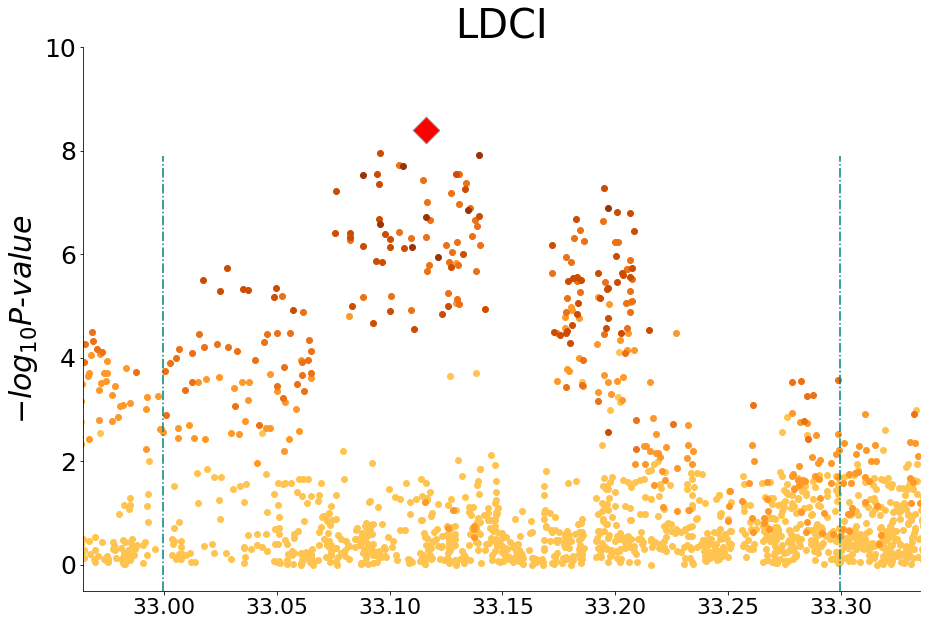

LD_block: chr14:11463826-13182363
plot region: chr14:11143633-13502555


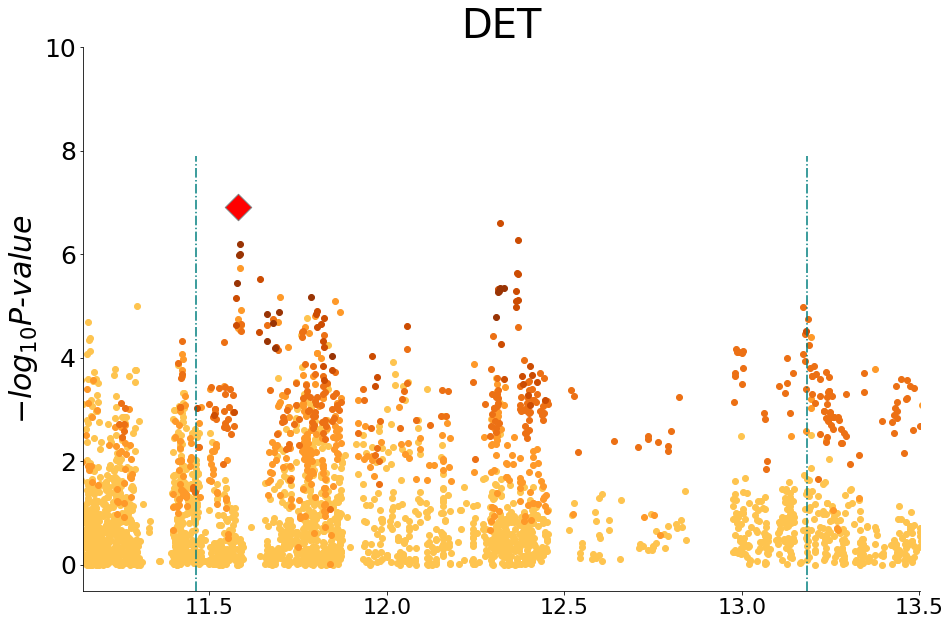

LD_block: chr17:13691961-14019630
plot region: chr17:13632825-14078765


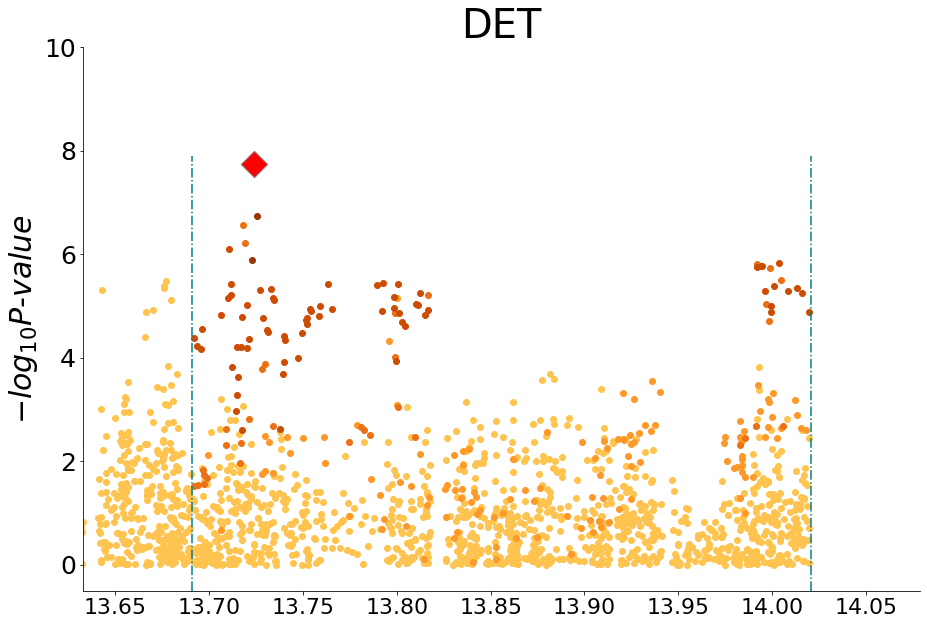

LD_block: chr05:12119942-13471630
plot region: chr05:11915838-13675733


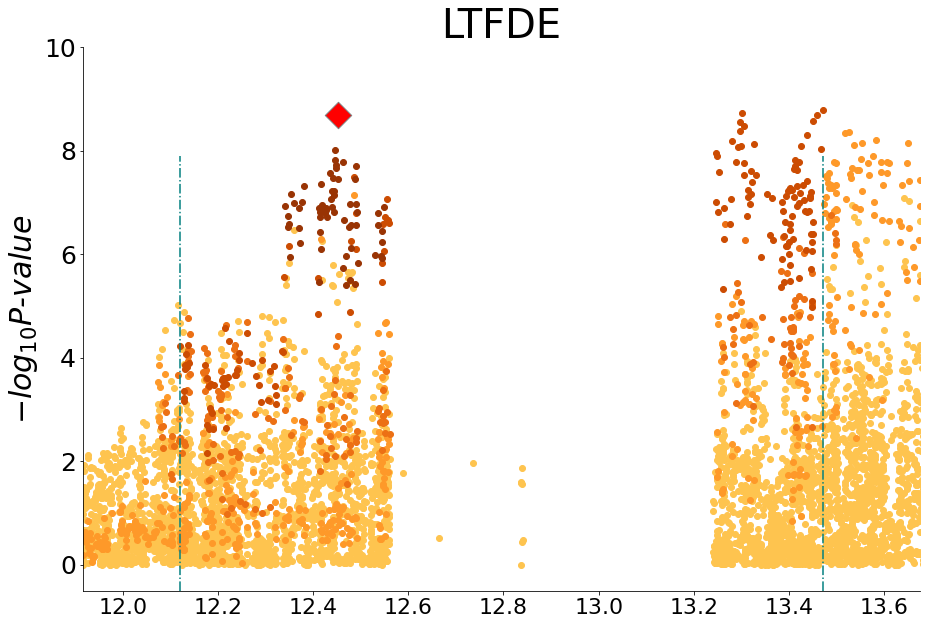

LD_block: chr05:66820226-67144845
plot region: chr05:66783124-67181946


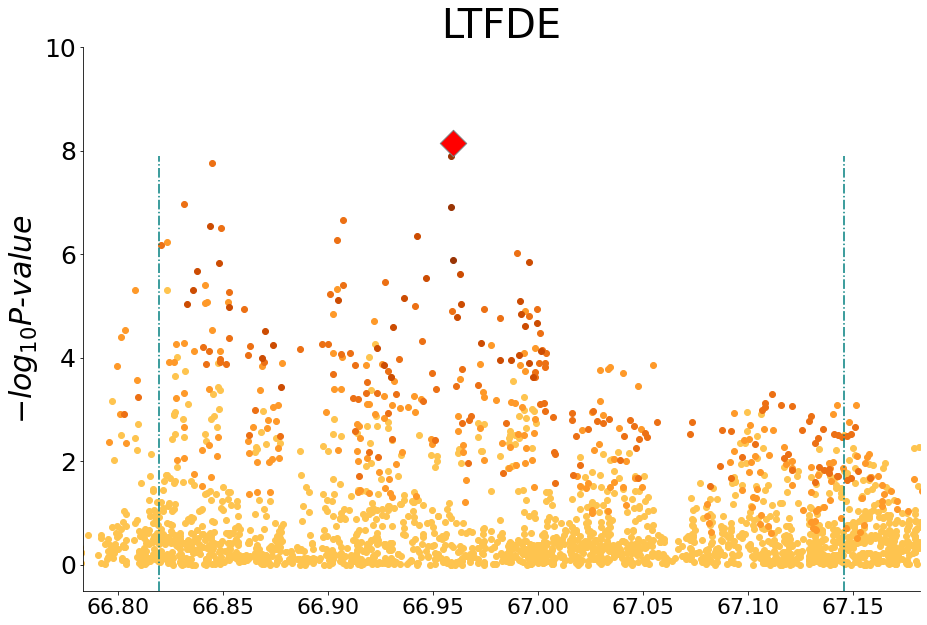

LD_block: chr02:48309970-48580925
plot region: chr02:48276610-48614284


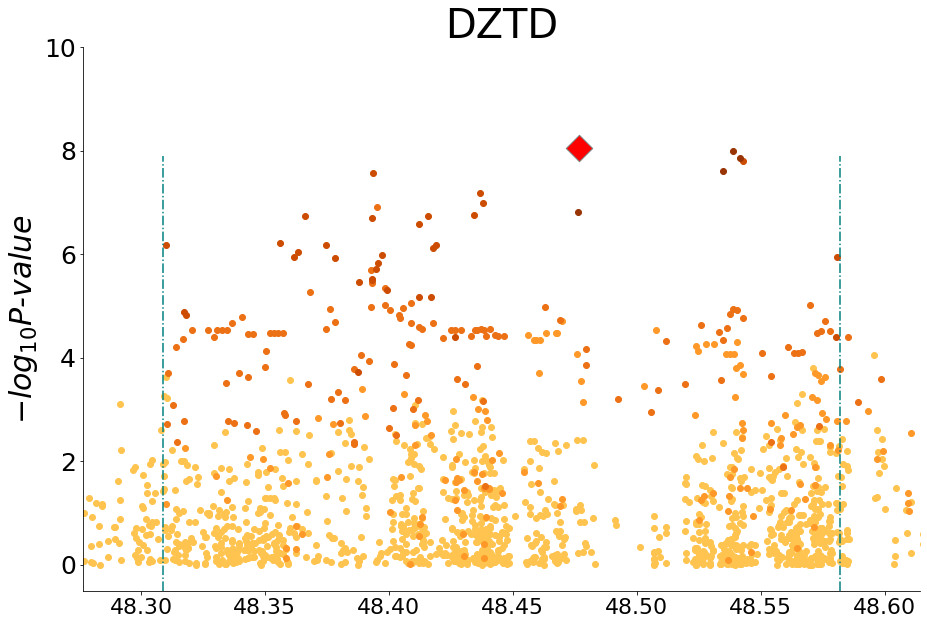

LD_block: chr05:3064373-3148858
plot region: chr05:3053835-3159395


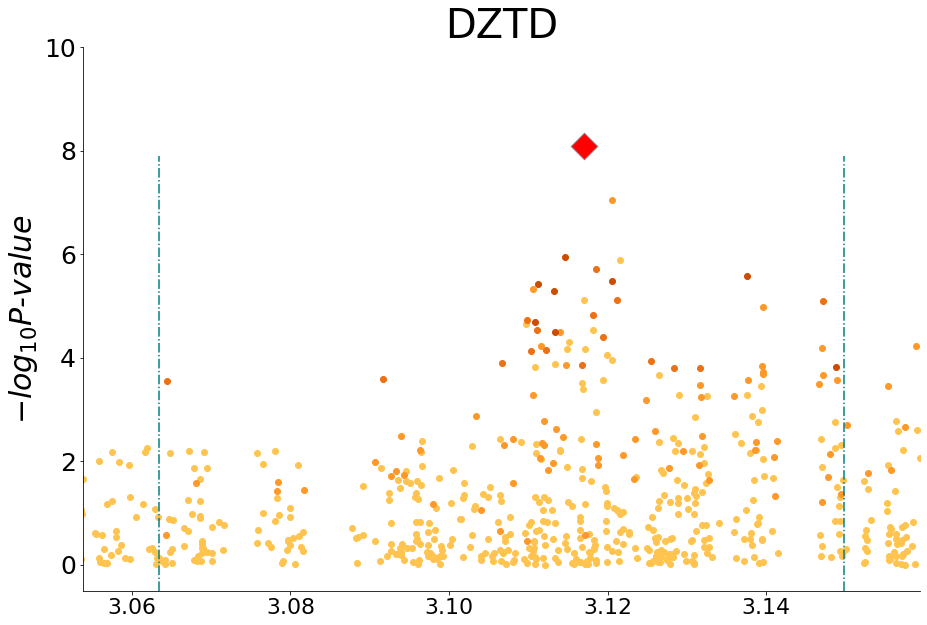

LD_block: chr13:1821356-1994791
plot region: chr13:1801564-2014582


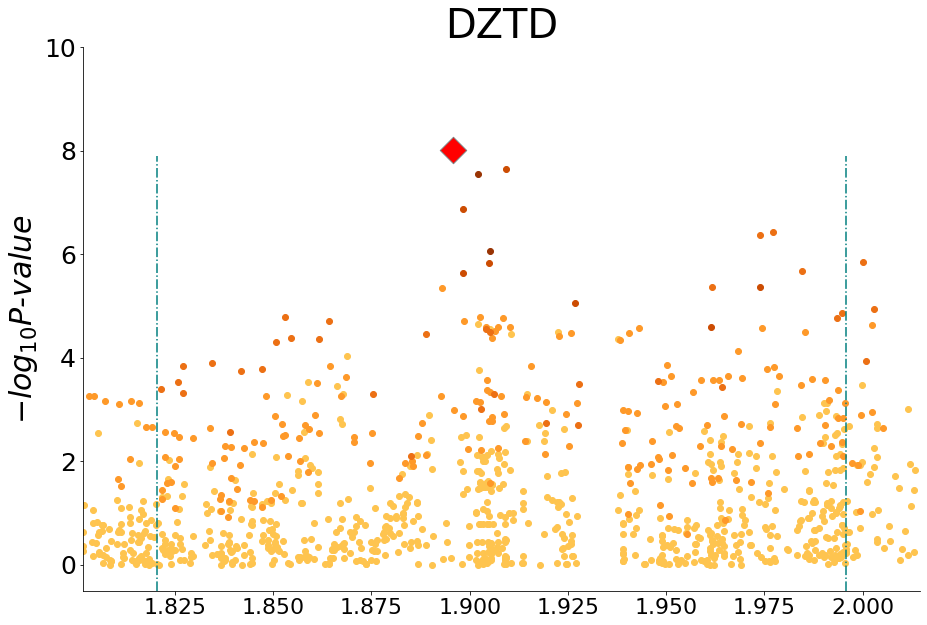

LD_block: chr05:12127539-13471630
plot region: chr05:11916119-13683050


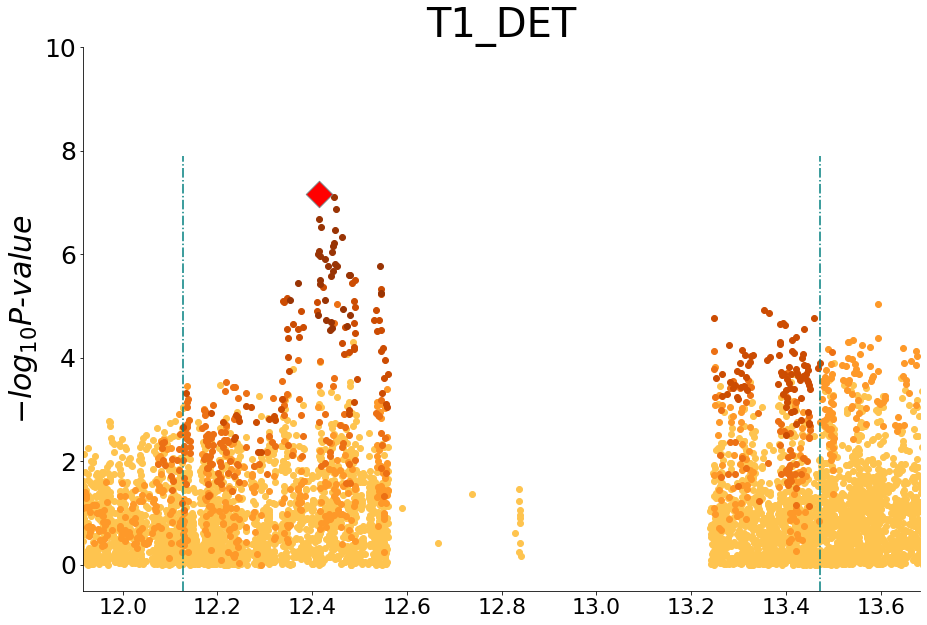

LD_block: chr01:53376636-53789539
plot region: chr01:53314568-53851606


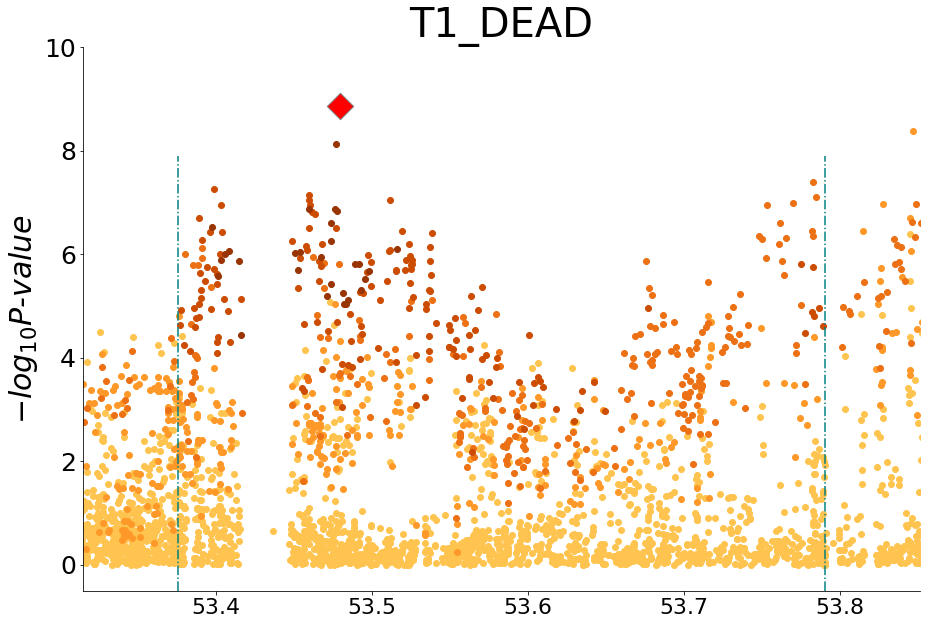

LD_block: chr05:45334941-48255693
plot region: chr05:44866342-48724291


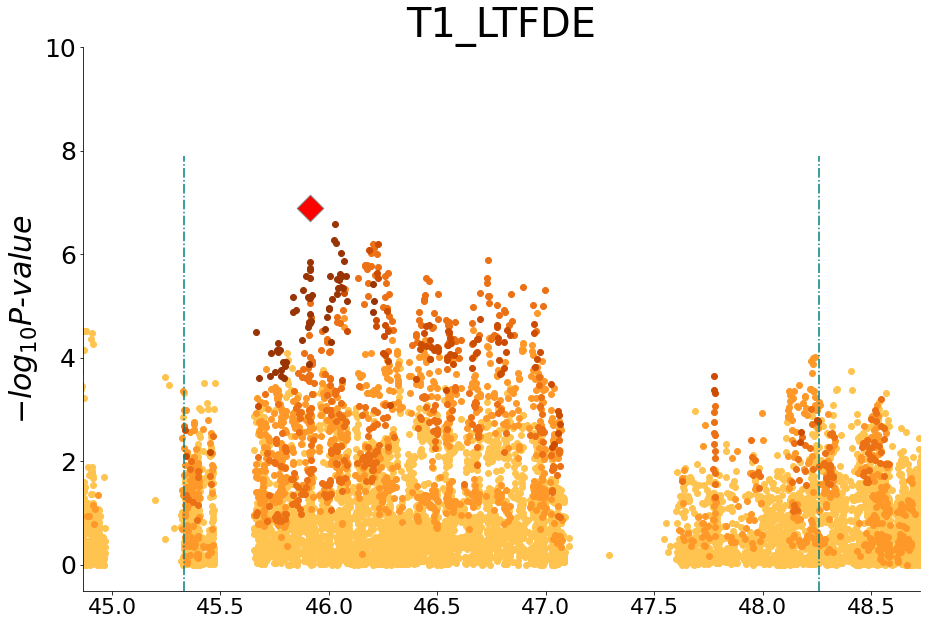

LD_block: chr02:33646066-34454726
plot region: chr02:33560681-34540110


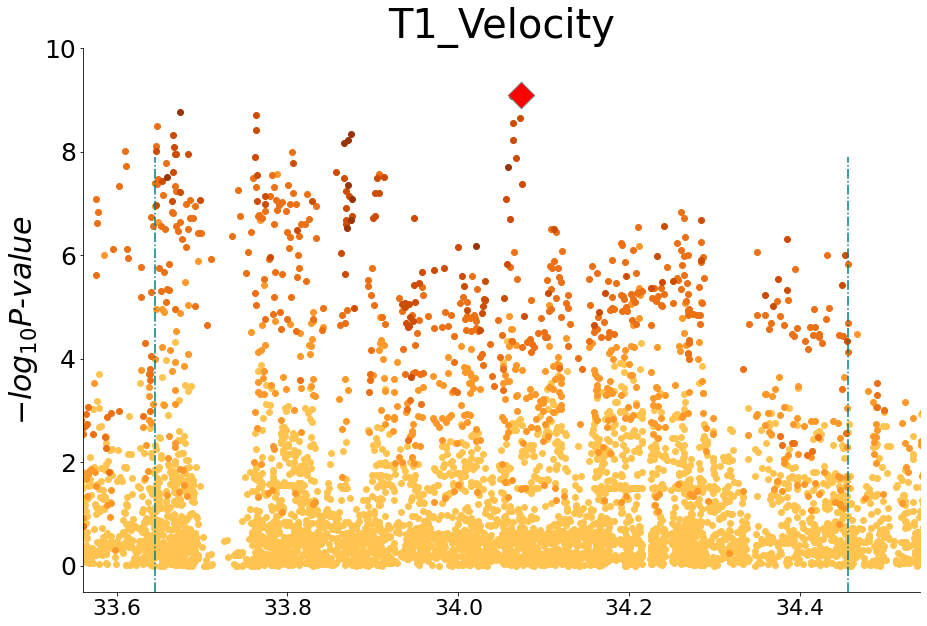

LD_block: chr02:33646066-34454726
plot region: chr02:33562766-34538025


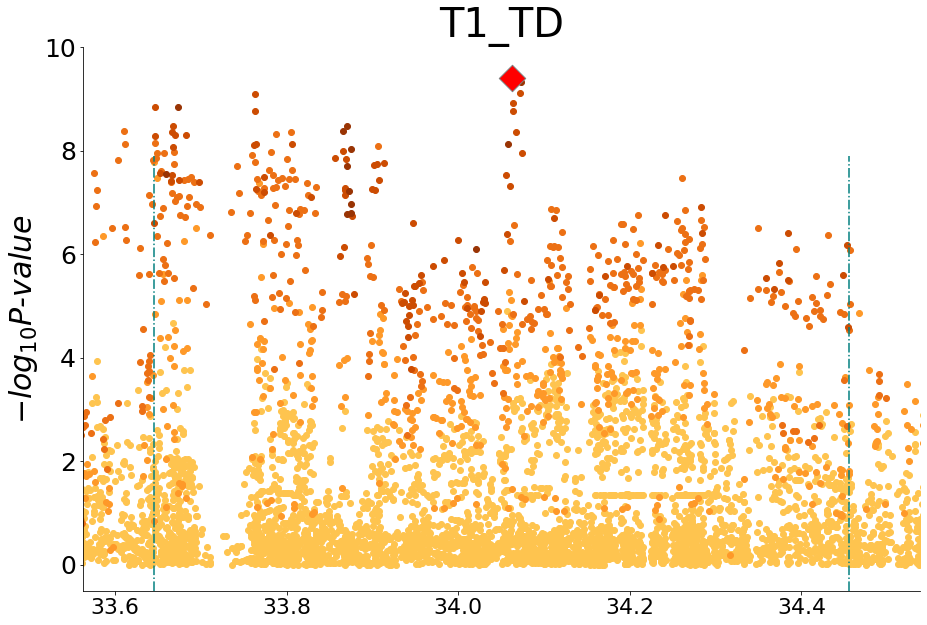

LD_block: chr20:13681243-15606526
plot region: chr20:13369115-15918653


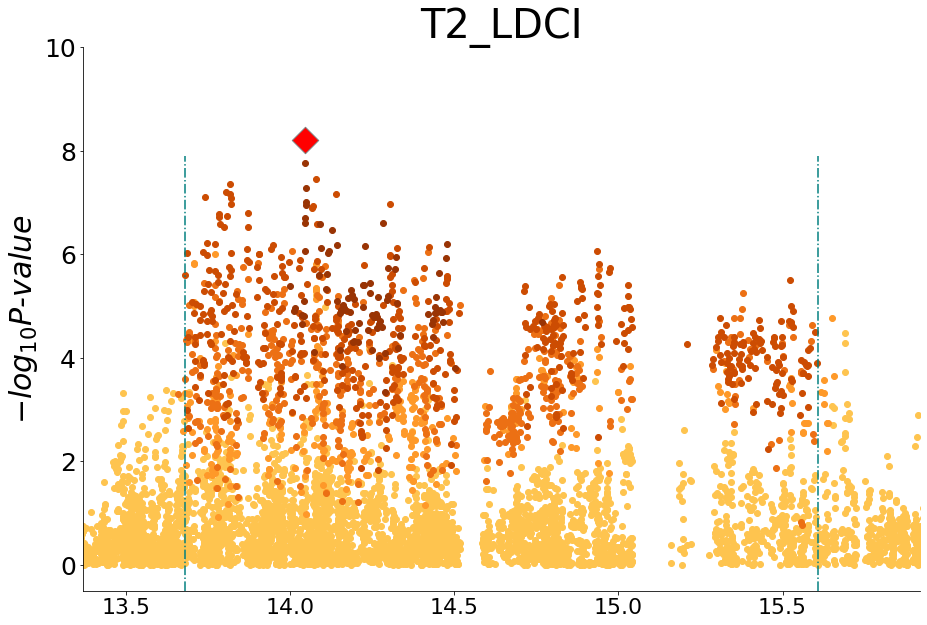

LD_block: chr03:52792596-52917553
plot region: chr03:52778365-52931783


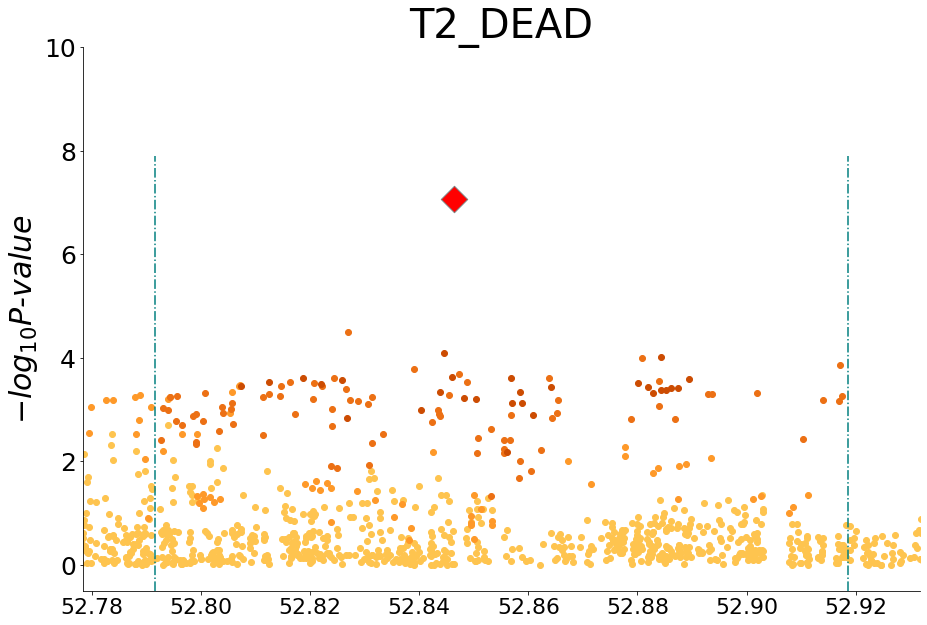

LD_block: chr02:8606924-8956209
plot region: chr02:8538627-9024505


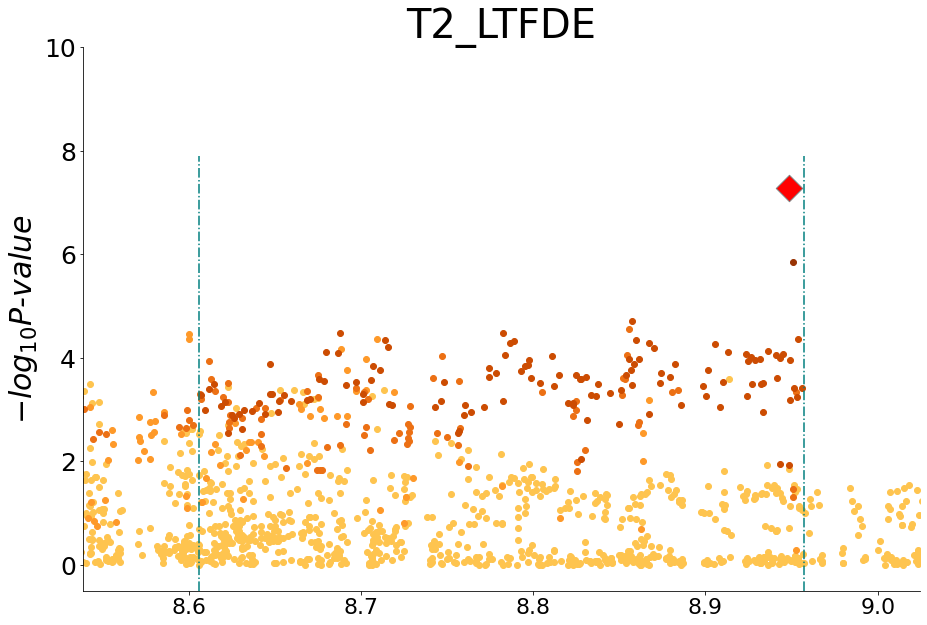

LD_block: chr14:11467285-14825582
plot region: chr14:11120962-15171904


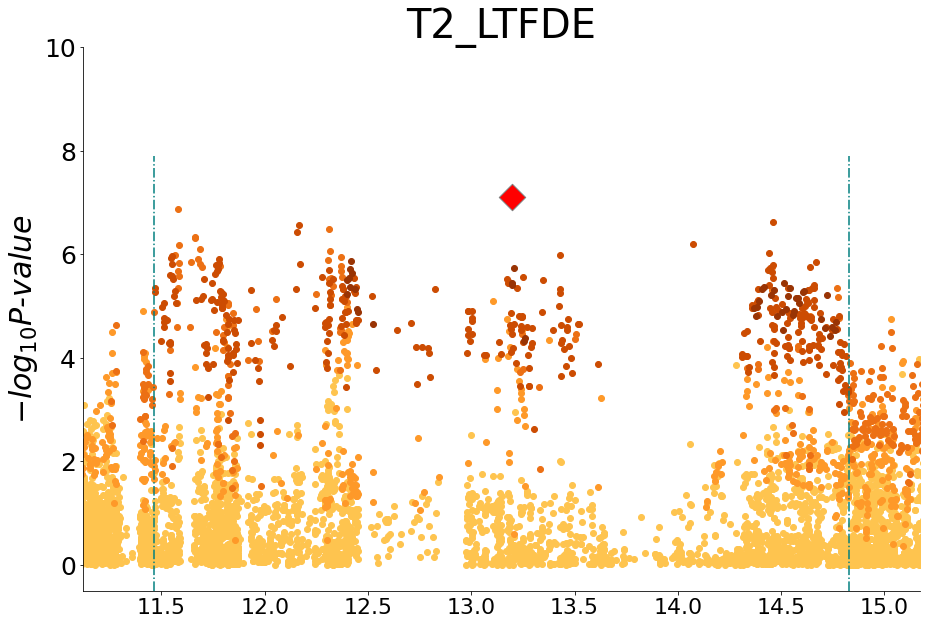

LD_block: chr17:13691961-14019630
plot region: chr17:13646547-14065044


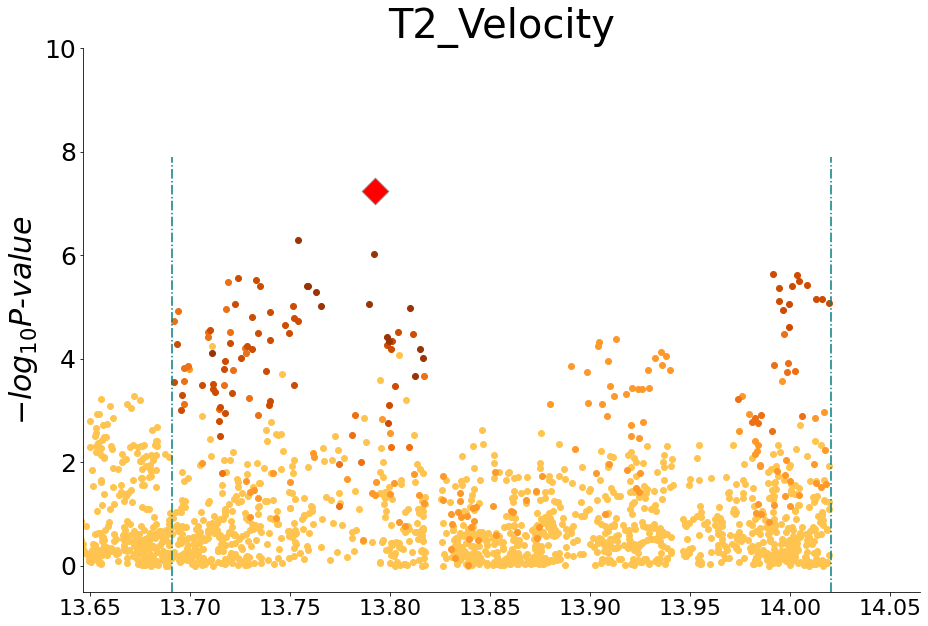

LD_block: chr14:11549027-14584147
plot region: chr14:10986082-15147091


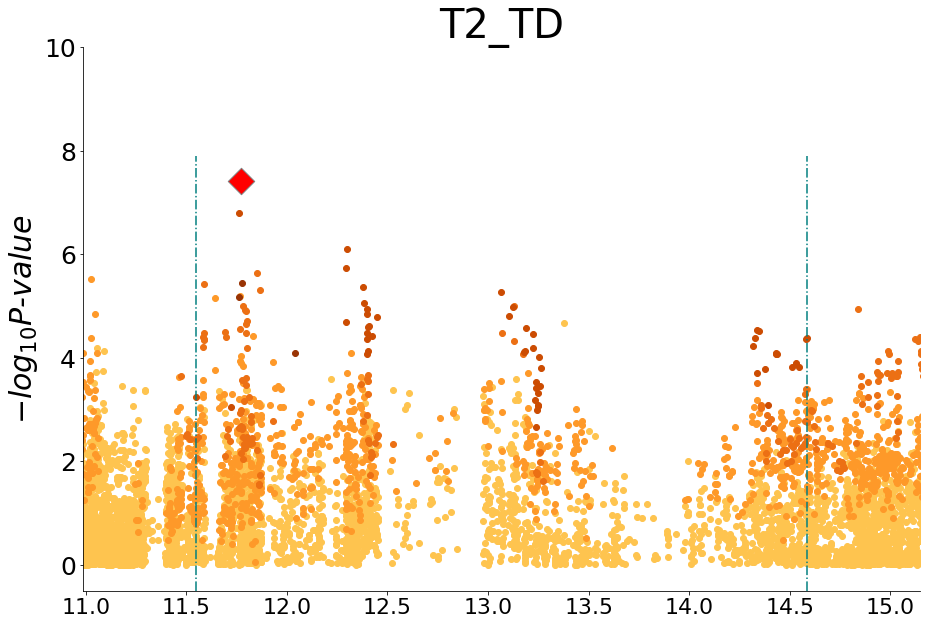

LD_block: chr05:66820226-67144845
plot region: chr05:66783124-67181946


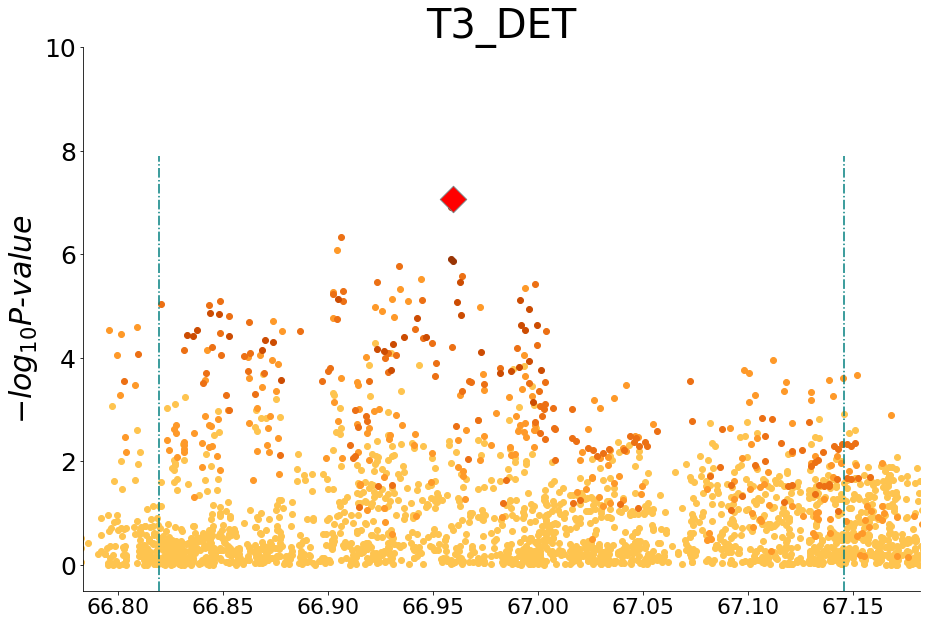

LD_block: chr20:27240341-28515033
plot region: chr20:27084823-28670550


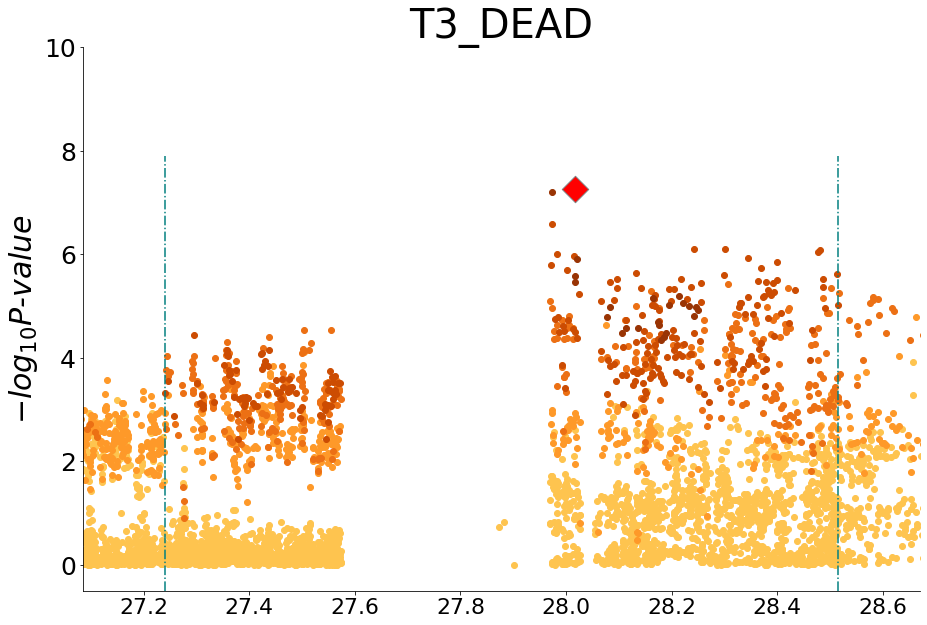

LD_block: chr14:50798800-51273322
plot region: chr14:50745971-51326151


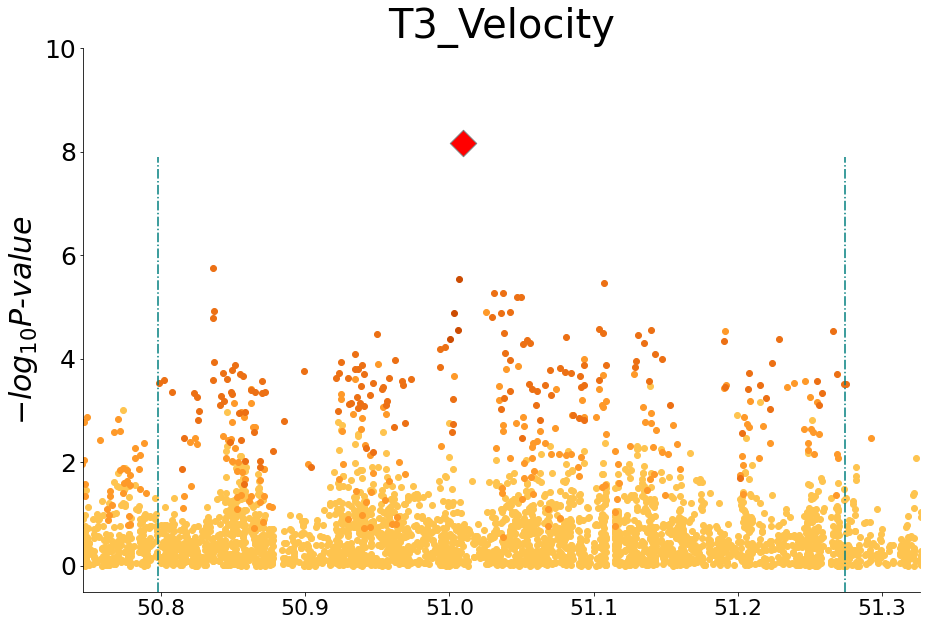

LD_block: chr14:50798800-51273322
plot region: chr14:50745971-51326151


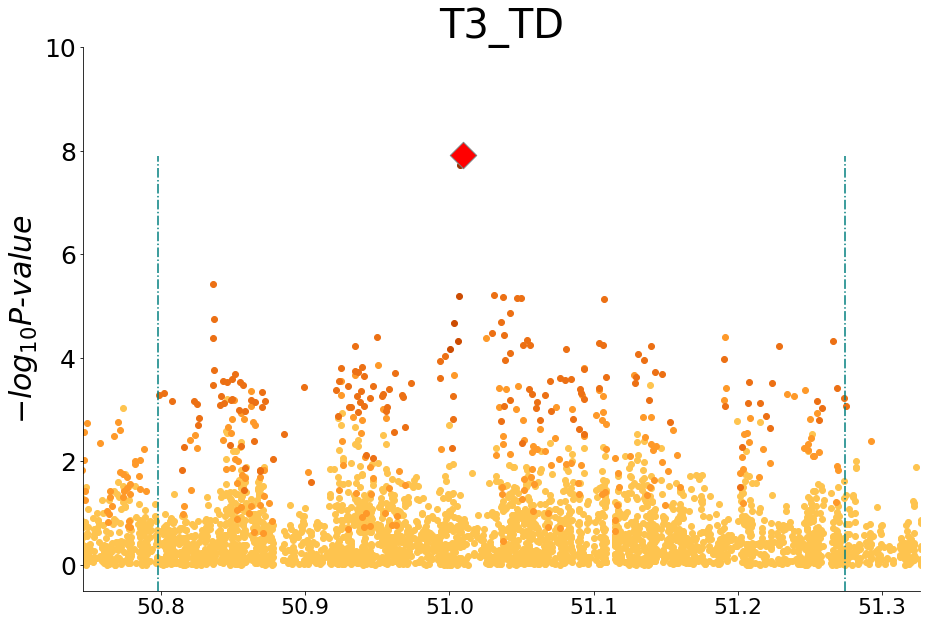

LD_block: chr20:3952155-4211592
plot region: chr20:3917077-4246669


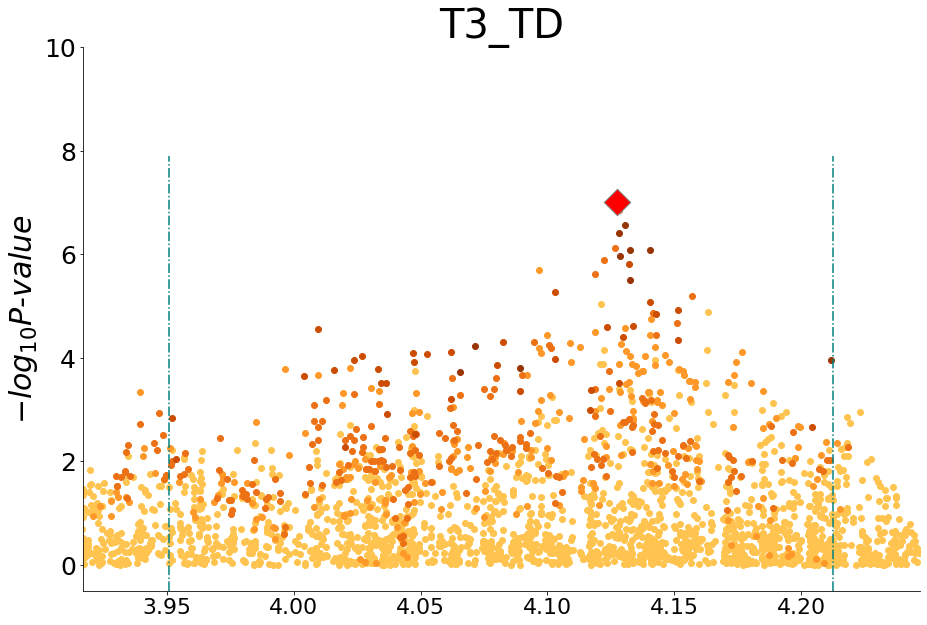

LD_block: chr17:36196042-36903822
plot region: chr17:36100656-36999207


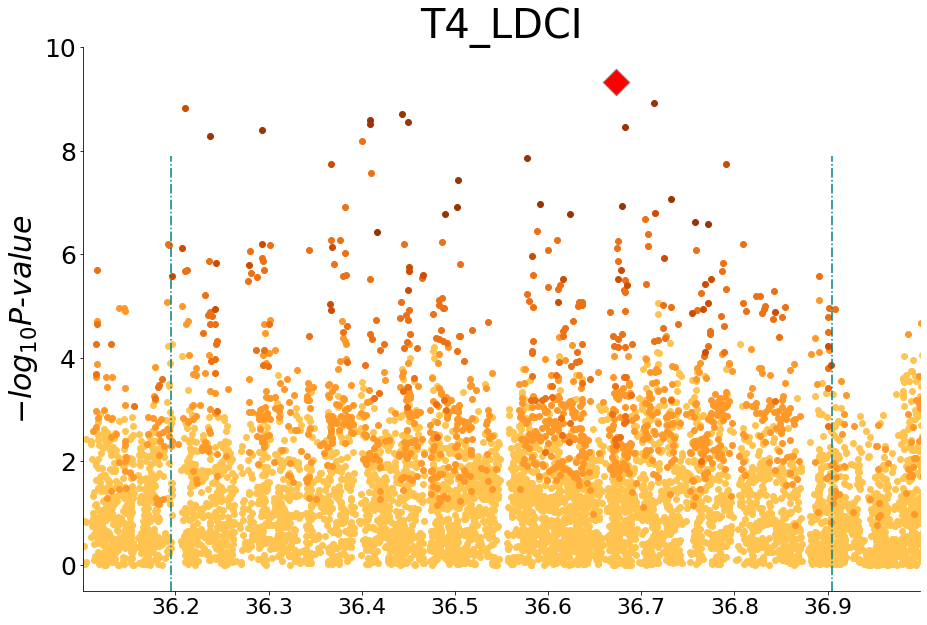

LD_block: chr01:11690229-13456076
plot region: chr01:11392190-13754114


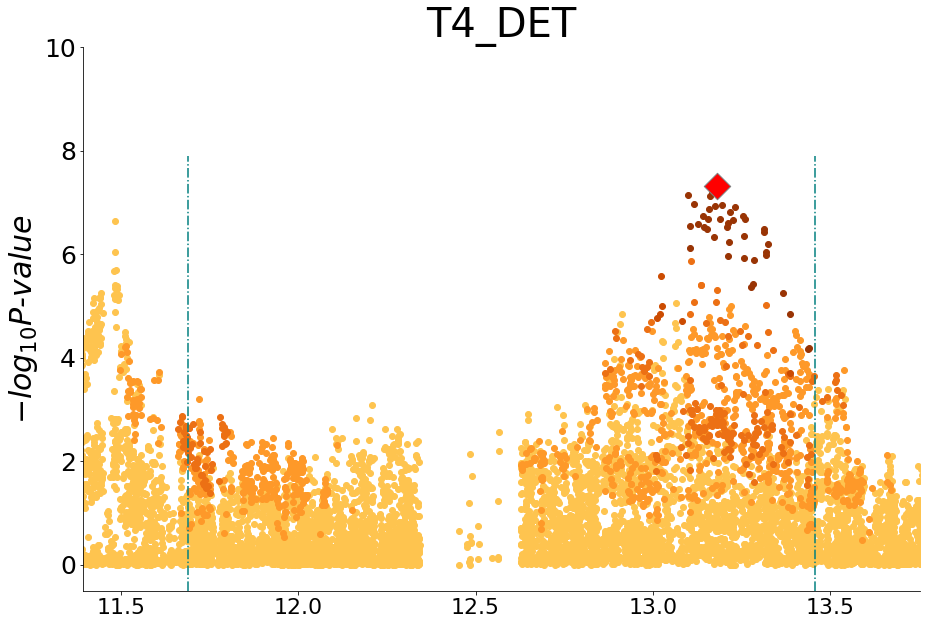

LD_block: chr03:40121331-40121382
plot region: chr03:40121320-40121392


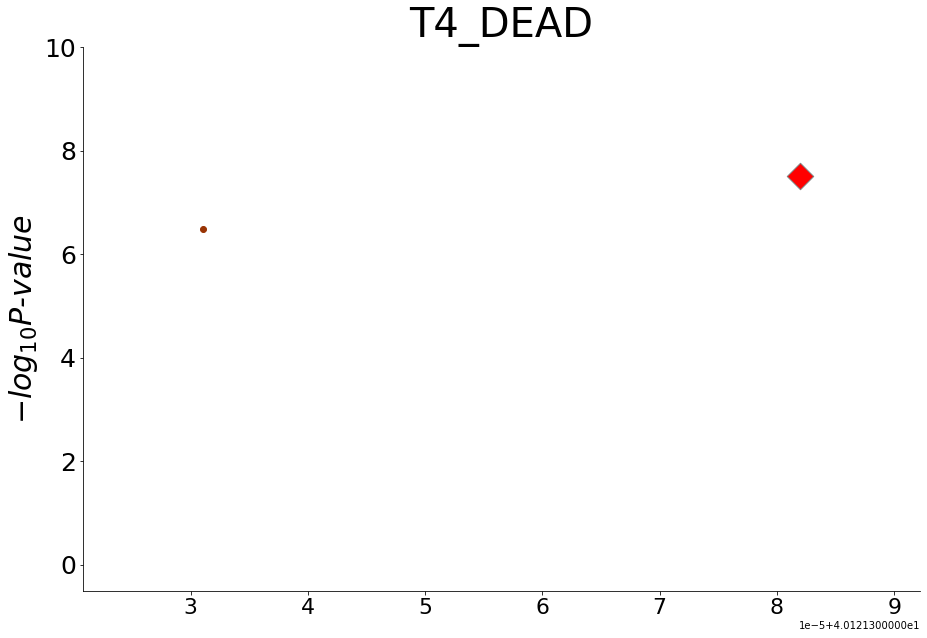

LD_block: chr11:25081486-29134485
plot region: chr11:24382478-29833492


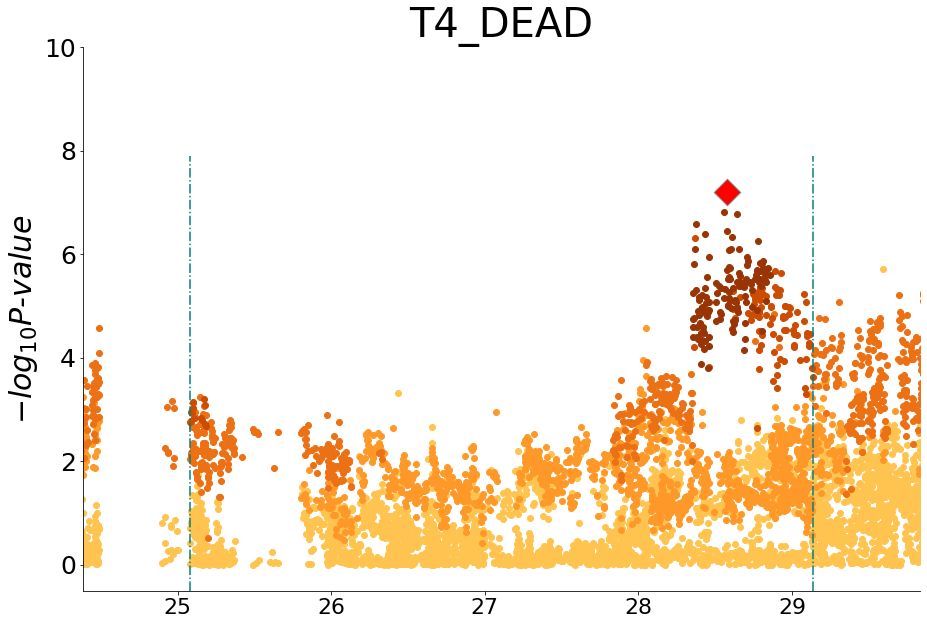

LD_block: chr23:4085951-4957204
plot region: chr23:3920782-5122372


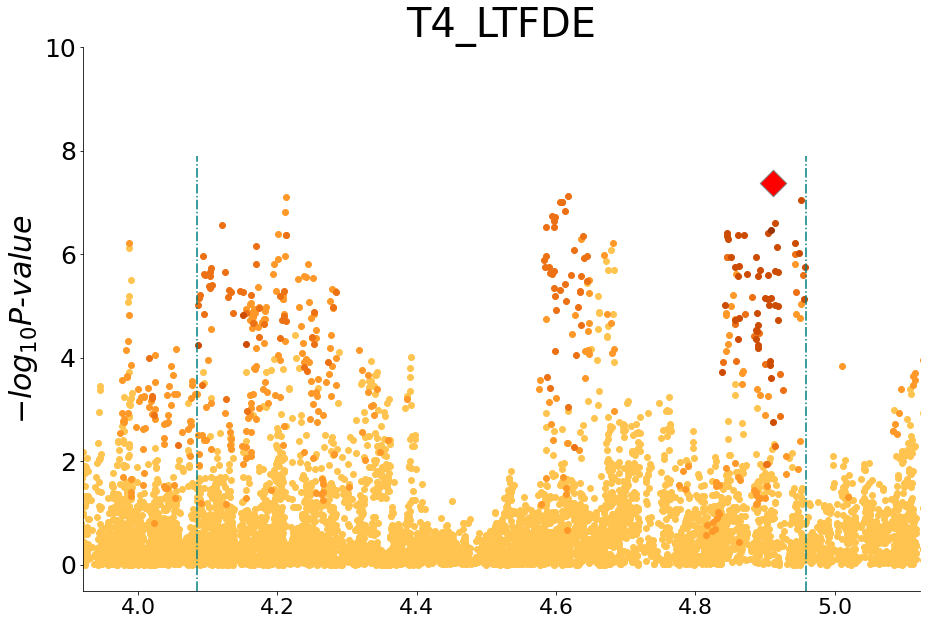

LD_block: chr20:44959393-45776340
plot region: chr20:44799757-45935975


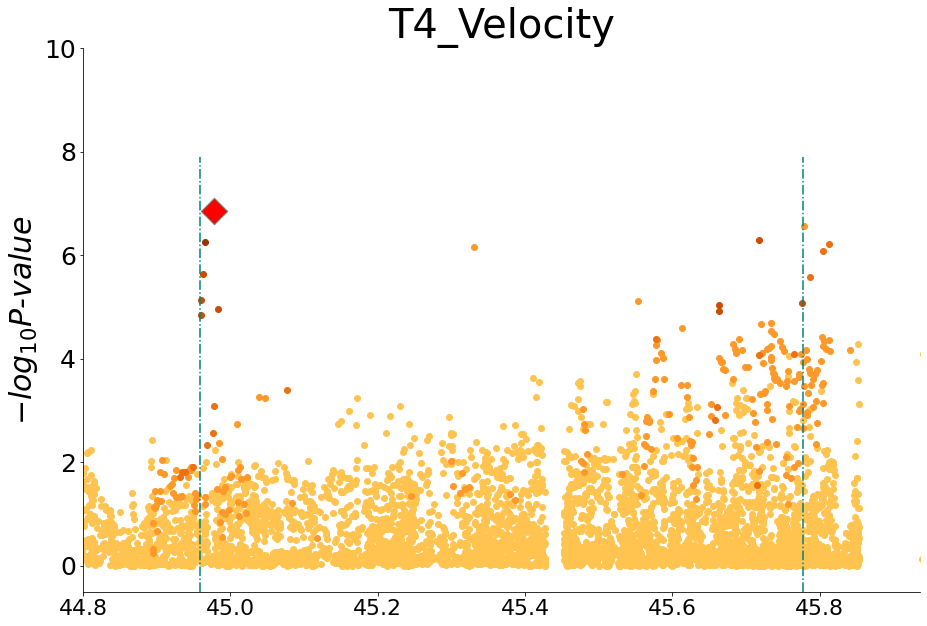

LD_block: chr08:16465036-18189702
plot region: chr08:16204035-18450702


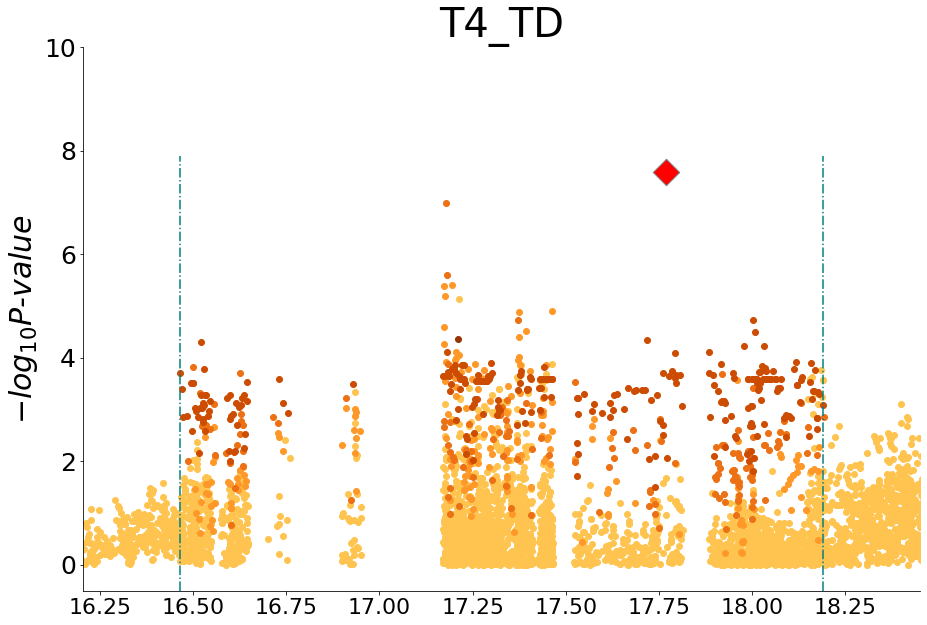

LD_block: chr13:1898171-2234760
plot region: chr13:1846679-2286251


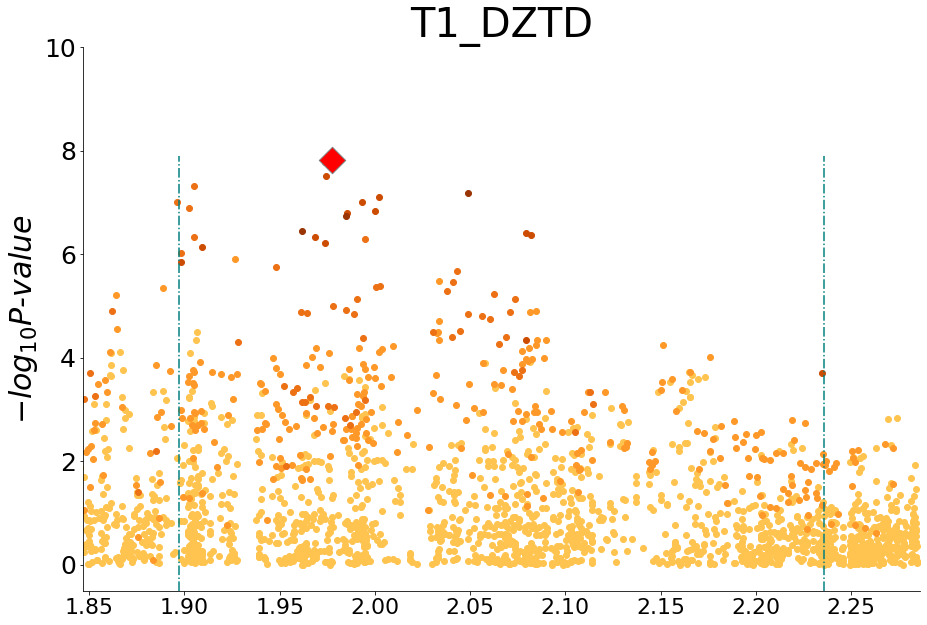

LD_block: chr20:13681243-15606526
plot region: chr20:13369115-15918653


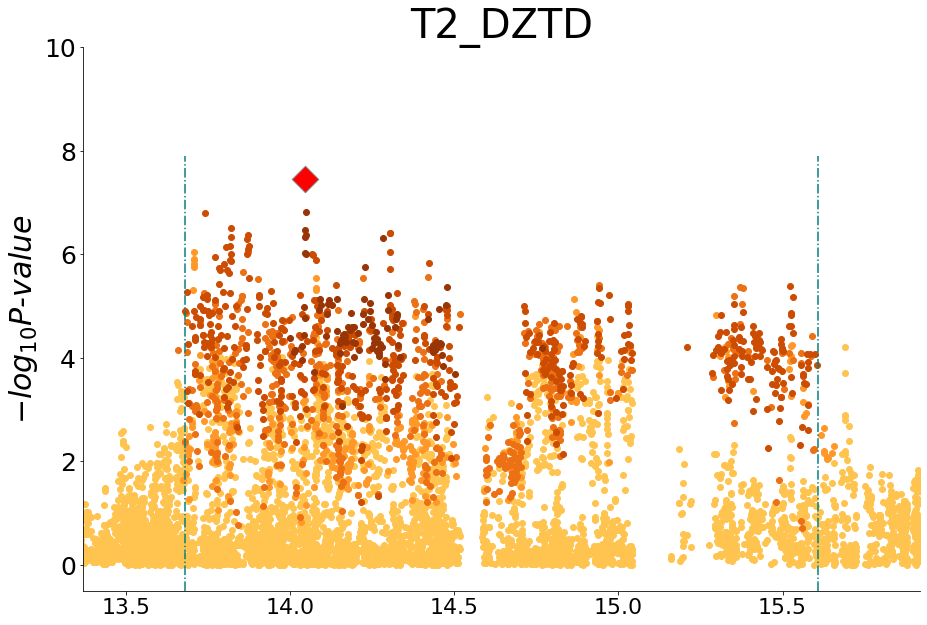

LD_block: chr25:17653244-17682598
plot region: chr25:17647378-17688463


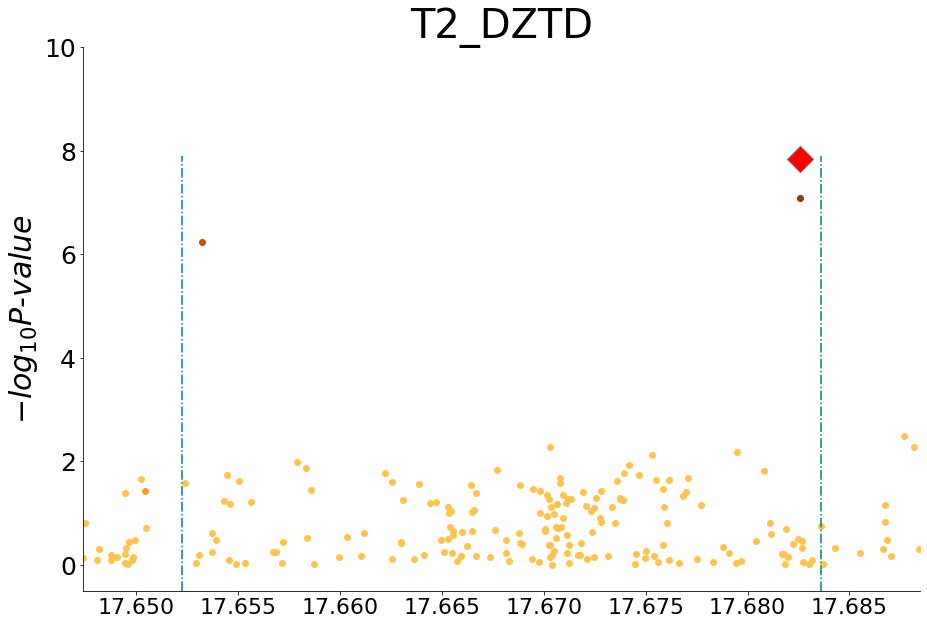

LD_block: chr05:66820226-67144845
plot region: chr05:66783124-67181946


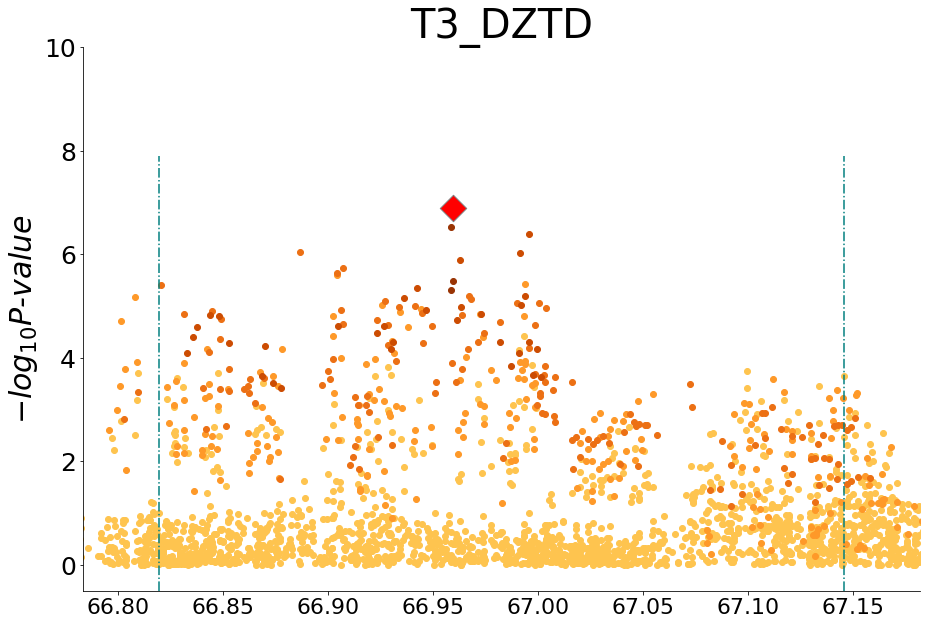

LD_block: chr13:46594400-46743053
plot region: chr13:46575815-46761637


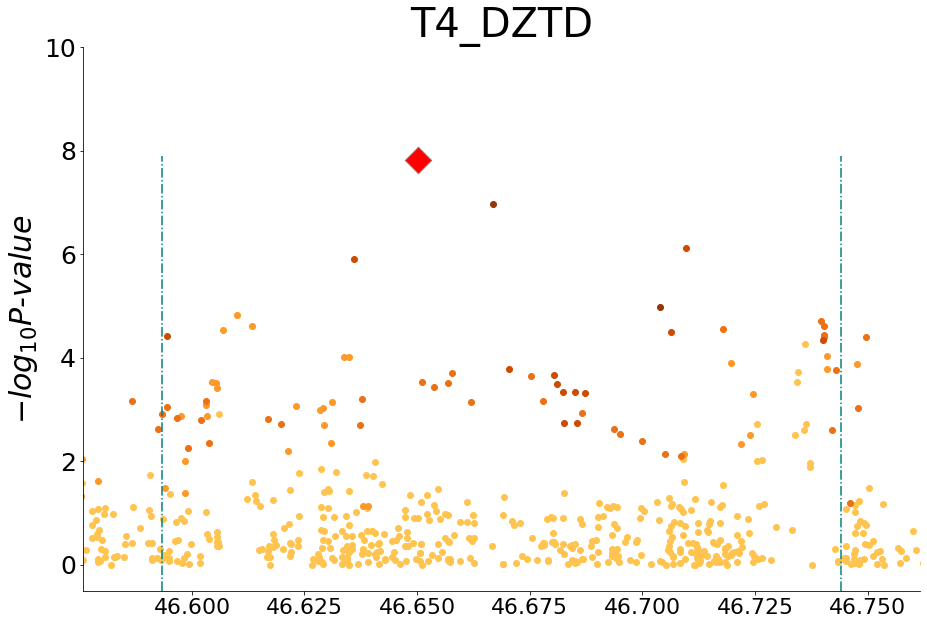

LD_block: chr17:36196042-36903822
plot region: chr17:36100656-36999207


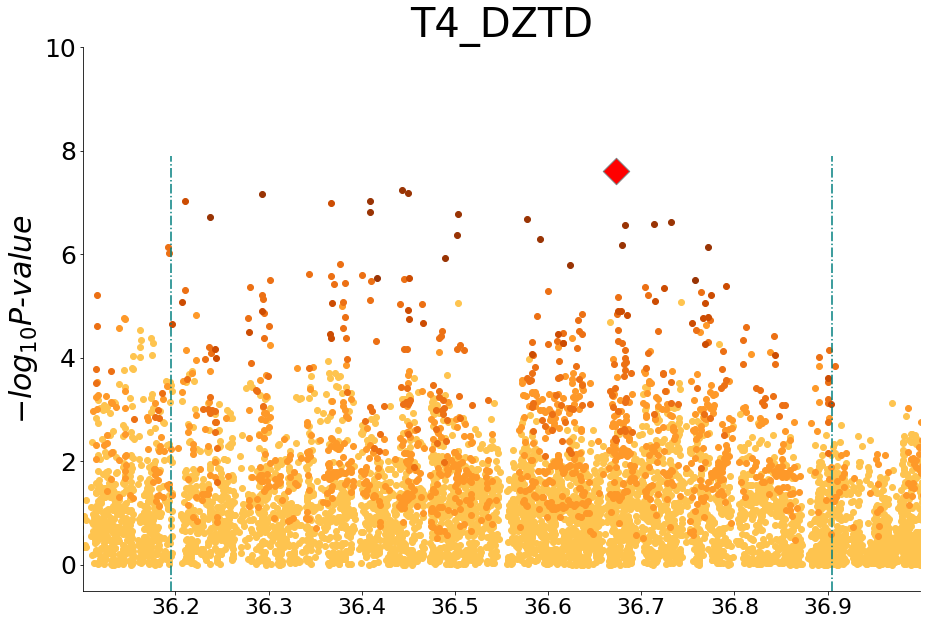

In [100]:
output_path = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_block/20220822/'
for i,snp in enumerate(df_ld_block.index):
    figure = Draw_LD_Block(df_ld_block, snp, i,output_path)

In [78]:
gene_num_list = []
for i, snp in enumerate(df_ld_block.index):
    gene_num = df_ld_block.loc[snp]['genes_in_small_block'].shape[0]
    gene_num_list.append(gene_num)
df_gene_num = pd.Series(gene_num_list)

In [80]:
df_gene_num.index = df_ld_block.index
df_gene_num = df_gene_num.loc[df_gene_num>0].reset_index().drop_duplicates('Peak_SNP')
df_gene_num

Peak_SNP   0
0    2:44880680  45
1     5:3117060   2
2   14:46314911  21
3   17:33116150   1
4   14:11581401  18
5   17:13723952   1
6    5:12451112  28
7    5:66959339   3
8    2:48476767   9
10   13:1895832   2
11   5:12414530  28
12   1:53479201  12
13   5:45912699  25
14   2:34072988  18
15   2:34062563  18
16  20:14045887   2
17   3:52846402   1
18    2:8948407   8
19  14:13198899  34
20  17:13792560   1
21  14:11769426  23
23  20:28017927  26
24  14:51009177   2
26   20:4127543   9
27  17:36672970   2
28   1:13180420   2
29   3:40121382   1
30  11:28576523  73
31   23:4911792  27
32  20:44978164   8
33   8:17770038  40
34   13:1977303   6
37  13:46650132   2

In [81]:
df_gene_num.min()

Peak_SNP    11:28576523
0                     1
dtype: object

In [82]:
df_gene_num.max()

Peak_SNP    8:17770038
0                   73
dtype: object

In [83]:
df_gene_num.mean()

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


0    15.090909
dtype: float64

LD_block: chr05:66820226-67144845
plot region: chr05:66783124-67181946


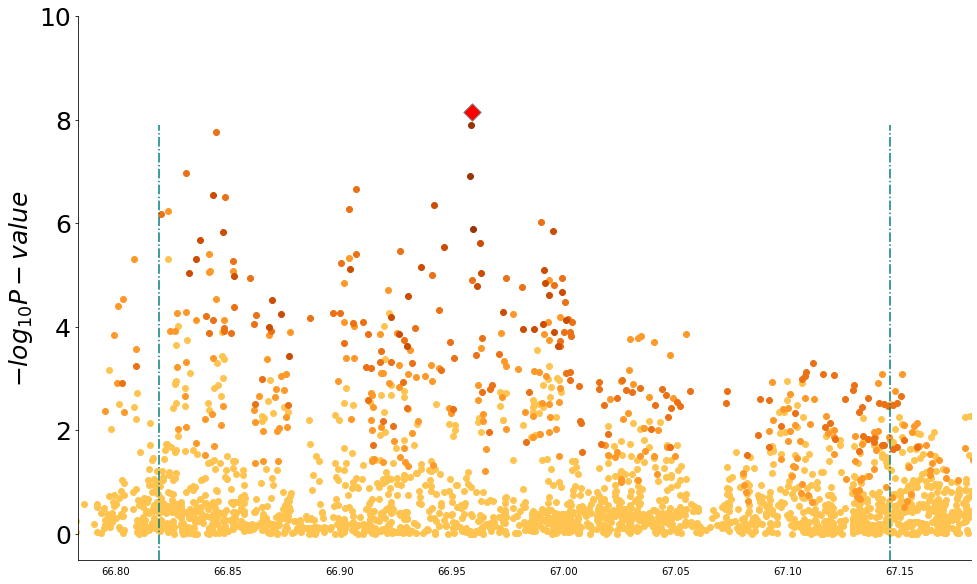

In [35]:
def Draw_LD_Block(df_ld_block_all, snp, order, output_path):
    
    
    chr_num=snp.split(":")[0]
    
    if int(chr_num)<10:
        chr_num='0'+chr_num
    else:
        chr_num=chr_num
    chr_num='chr'+chr_num 
    
    df_LDblock=df_ld_block_all.iloc[order,:]['SNPs_nearby']
    peak_logP=df_ld_block_all.iloc[order,:]['peak_snp_log10P']
    trait = df_ld_block_all.iloc[order,:]['trait']
    peak_pos=int(snp.split(":")[1])
    
    if df_ld_block_all.iloc[order,:]['genes_in_small_block'].shape[0]>5:
        left=df_ld_block_all.iloc[order,:]['small_block_start']
        right=df_ld_block_all.iloc[order,:]['small_block_end']
        
    else:
        left=df_ld_block_all.iloc[order,:]['big_block_start']
        right=df_ld_block_all.iloc[order,:]['big_block_end']
    
    interval = max(abs(peak_pos-left), abs(peak_pos-right))
    
    df_LDblock=df_LDblock.loc[(df_LDblock['pos']>(min(left, peak_pos)*0.9))&(df_LDblock['pos']<(max(right, peak_pos)*1.1))]
    
    df_plot=df_ld_block_all.iloc[order,:]['SNPs_nearby']
    
    df_plot_g2=df_plot.loc[(df_plot['r2']>0.6)&(df_plot['r2']<0.8)]
    df_plot_g3=df_plot.loc[(df_plot['r2']>0.4)&(df_plot['r2']<0.6)]
    df_plot_g4=df_plot.loc[(df_plot['r2']>0.2)&(df_plot['r2']<0.4)]
    df_plot_g5=df_plot.loc[(df_plot['r2']<0.2)]
    df_plot_g1=df_plot.loc[df_plot['r2']>0.8]
    f = plt.figure(figsize=(16,10))
    color_platte = ['#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#ff0000']
    #color_platte = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#ff0000']
    plt.scatter(df_plot_g5['pos']/1000000, df_plot_g5['-log10_P'], c=color_platte[0], label='r2<0.2')
    plt.scatter(df_plot_g4['pos']/1000000, df_plot_g4['-log10_P'], c=color_platte[1], label='0.2<r2<0.4')
    plt.scatter(df_plot_g3['pos']/1000000, df_plot_g3['-log10_P'], c=color_platte[2], label='0.4<r2<0.6')
    plt.scatter(df_plot_g2['pos']/1000000, df_plot_g2['-log10_P'], c=color_platte[3], label='0.6<r2<0.8')
    plt.scatter(df_plot_g1['pos']/1000000, df_plot_g1['-log10_P'], c=color_platte[4], label='0.8<r2<1')
    plt.scatter(x=peak_pos/1000000, y=peak_logP, c=color_platte[5], label='r2=1', s=150, marker='D', edgecolor='grey')
    ax=plt.gca()
    plt.ylim(-0.5,10)
    plt.xlim((min(left, peak_pos)-interval*0.2)/1000000, (max(right, peak_pos)+interval*0.2)/1000000)
    #plt.xlim((peak_pos-interval-10000)/1000000, (peak_pos+interval+10000)/1000000)
    plt.ylabel(r'$-log_{10}P-value$', fontsize=25)
    plt.tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are on
                    top=False,         # ticks along the top edge are off
                    labelbottom=True)
    plt.yticks(size=25)
    plt.axvline(x = (min(left, peak_pos)-1000)/1000000, c='#007f7f', linestyle = '-.', ymax = 0.8)
    plt.axvline(x = (max(right, peak_pos)+1000)/1000000, c='#007f7f', linestyle = '-.', ymax = 0.8)
    print('LD_block: %s:%i-%i'%(chr_num, (min(left, peak_pos)), max(right, peak_pos)))
    print('plot region: %s:%i-%i'%(chr_num, min(left, peak_pos)-interval*0.2, max(right, peak_pos)+interval*0.2))
    #plt.title(trait,size=40)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(output_path+trait+'_LD_'+chr_num+'_'+str(peak_pos)+'_snp.tif',bbox_inches='tight')
    plt.show()
    #return f
Draw_LD_Block(df_ld_block, '5:66959339', 7,output_path)

## Credit set of SNP identification

In [9]:
def file_prep(target_trait, peak_snp):
    traitlist = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MLMA/20220614/traits.txt',sep=' ')
    traitlist = list(traitlist.columns)[1:]
    mlma_v5 = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MLMA/20220614/'
    trait_num = traitlist.index(target_trait)+1
    df_mlma_pruned_v5 = pd.read_csv(mlma_v5+'Trait'+str(trait_num)+'.loco.mlma', sep='\t', header=0)
    df_mlma_pruned_v5.insert(0, '-log10_P', df_mlma_pruned_v5['p'].apply(lambda x: math.log(x, 10)*(-1)))
    df_mlma_pruned_v5.drop('Unnamed: 0',axis=1, inplace=True)

    #peak_snp = '5:12451112
    df_temp = df_ld_block.loc[peak_snp]['SNPs_nearby']
    df_temp = df_temp.loc[(df_temp['pos']>=df_ld_block.loc[peak_snp]['small_block_start'])&
                         (df_temp['pos']<=df_ld_block.loc[peak_snp]['small_block_end'])].dropna()
    df_temp = df_mlma_pruned_v5.set_index('SNP').loc[df_temp.index.append(pd.Index([peak_snp]))]
    df_temp = df_temp.sort_values('bp')

    df_output = df_temp.iloc[:, 1:-1]
    df_output['maf'] = df_output['Freq'].apply(lambda x: x if x<0.5 else (1-x))
    df_output['chromosome'] = df_output['Chr'].apply(lambda x: str(x) if x>9 else('0'+str(x)))
    #df_output['prob'] = df_output['p'].apply(lambda x: 1-x)
    df_output = df_output[['chromosome', 'bp', 'A1', 'A2', 'maf', 'b', 'se']].reset_index()
    df_output.columns = ['rsid', 'chromosome', 'position', 'allele1', 'allele2', 'maf', 'beta', 'se']

    zfile_name = target_trait+'_'+peak_snp.replace(":", "_")
    df_output.to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Credit_set_snp/'+zfile_name+'.z', 
                     index=None, sep=" ")

    df_output['rsid'].to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Credit_set_snp/'\
                             +zfile_name+'_snp_list.txt', index=None, header=None)
    return df_temp
    

In [167]:
file_prep('T4_LDCI', '17:36400200')

In [10]:
def credible_snp_set(target_trait, peak_snp):
    zfile_name = target_trait+'_'+peak_snp.replace(":", "_")
    ##fine the config file 
    df_config = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Credit_set_snp/'+zfile_name+'.config',
                        sep = ' ', index_col=1)
    top_config = [df_config.iloc[0, 0]] # find top causal configure
    L = len(top_config) # find number of causal SNPs in the top causal configure
    
    df_cred = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Credit_set_snp/'+zfile_name+'.cred'+str(L),
                        sep = ' ', skiprows = 5)
    df_cred['position'] = df_cred['cred'+str(L)].str.split(":").str[1].astype(int)
    
    if df_ld_block.loc[peak_snp]['genes_in_small_block'].shape[0]>10:
        left=df_ld_block.loc[peak_snp]['small_block_start']
        right=df_ld_block.loc[peak_snp]['small_block_end']
        
    else:
        left=df_ld_block.loc[peak_snp]['big_block_start']
        right=df_ld_block.loc[peak_snp]['big_block_end']
        
    peak_pos = int(peak_snp.split(":")[-1])
    interval = max(abs(peak_pos-left), abs(peak_pos-right))
    f, ax = plt.subplots(1,1, figsize = (15, 3))
    ax.scatter(y = df_cred['prob1'], x = df_cred['position']/1e6, c='#CE85D8', s = 100, edgecolor='black')
    ax.scatter(y = df_cred['prob1'][0], x = df_cred['position'][0]/1e6, c='#8FD885', s = 200, edgecolor='black')
    #ax.text(df_cred['position'][0]/1e6-0.01, df_cred['prob1'][0]-0.01, df_cred['cred1'][0],size=15)
    ax.set_xlim((min(left, peak_pos)-interval*0.2)/1000000, (max(right, peak_pos)+interval*0.2)/1000000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('posterior probability', size = 20)
    ax.text(0.4,1, 'CS size = '+str(df_cred.shape[0]),transform=ax.transAxes, size=15)
    plt.show()
    return df_cred

In [353]:
for peak_snp in df_ld_block.index:
    trait = df_ld_block.loc[peak_snp]['trait']
    
    print("'%s', '%s'"%(trait, peak_snp))
    file_prep(trait, peak_snp)

'LDCI', '2:44880680'
'LDCI', '5:3117060'
'LDCI', '14:46314911'
'LDCI', '17:33116150'
'PCCI', '11:29830387'
'PCCI', '14:22461182'
'PCCI', '23:34096507'
'DZE', '5:66958636'
'DZE', '14:11581401'
'DZE', '17:13723952'
'DZEAD', '2:45038809'
'LTFDZE', '5:12451112'
'LTFDZE', '5:66959339'
'Std_LDCIs', '23:8624915'
'T2_LDCI', '20:14046054'
'T4_LDCI', '17:36400200'


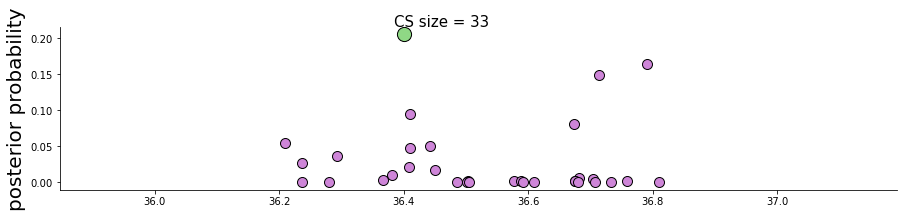

In [194]:
df_cred = credible_snp_set('T4_LDCI', '17:36400200')

In [3]:
##import data of regulatory elements
input_dir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Candidate_gene_prioritization/danRer11_annotations/'
df_cPADRE_list = []
for file in os.listdir(input_dir):
    if 'cPADREs' in file:
        stage = file.split("_")[0]
        df_cPADRE = pd.read_csv(input_dir+file,sep = '\t', header=None)
        df_cPADRE = df_cPADRE.loc[df_cPADRE[0].apply(lambda x: len(x))<=5].iloc[:, :]
        df_cPADRE['stage'] = stage
        df_cPADRE_list.append(df_cPADRE)

df_cPADRE_all_stage = pd.concat(df_cPADRE_list)
    

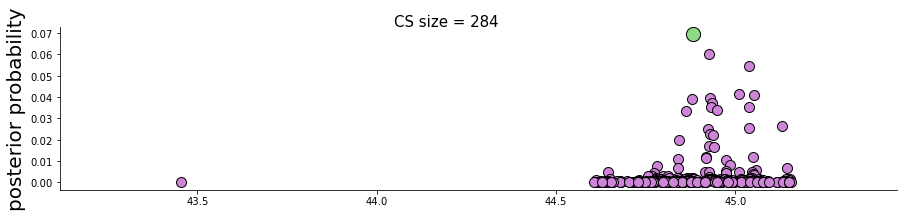

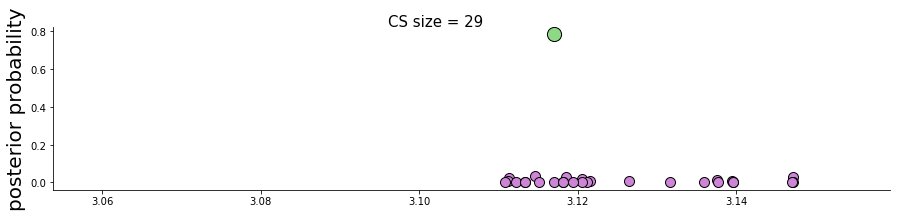

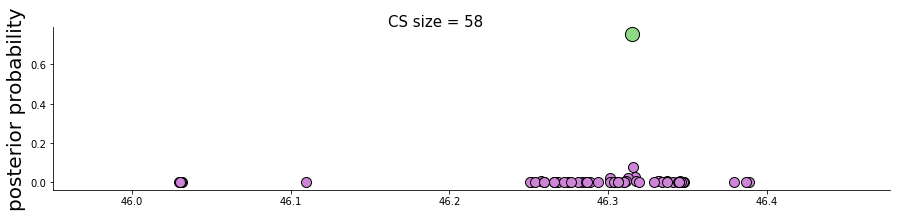

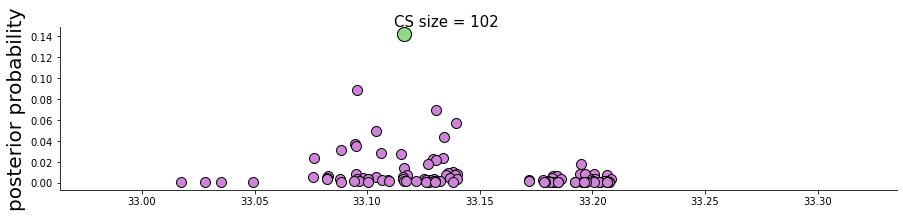

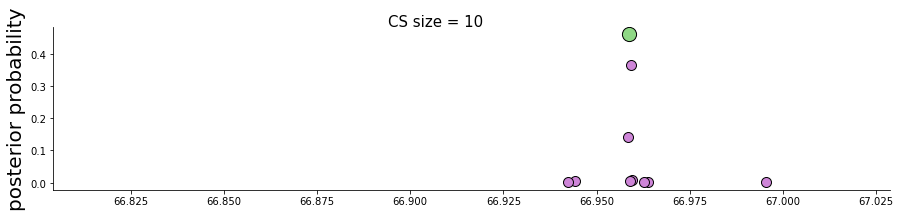

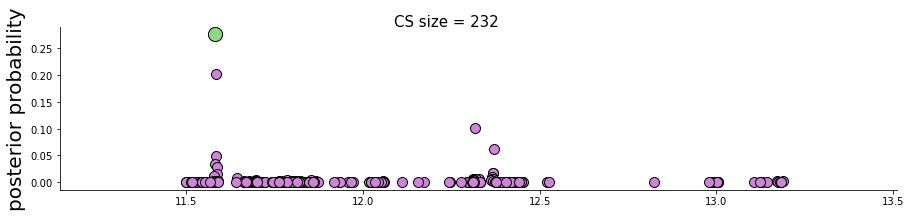

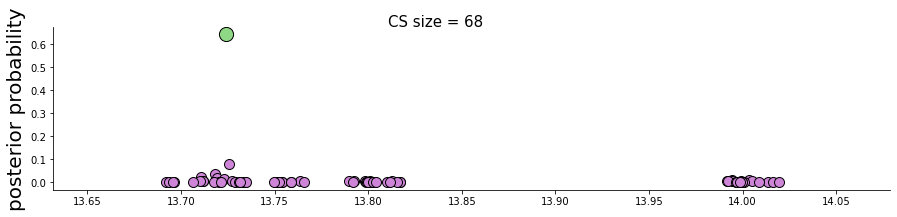

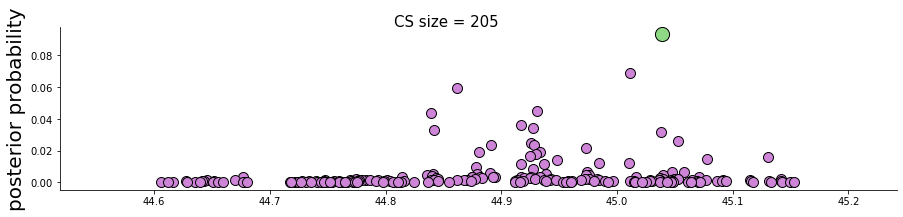

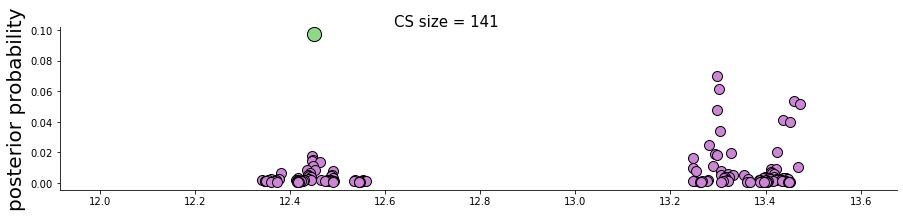

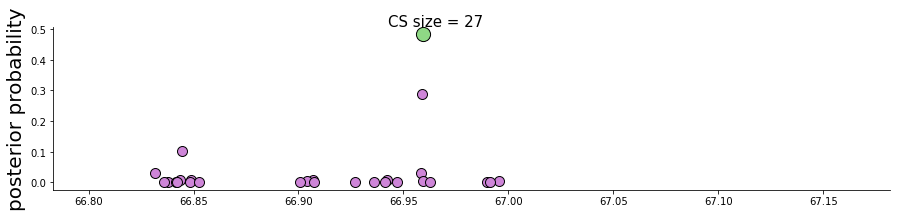

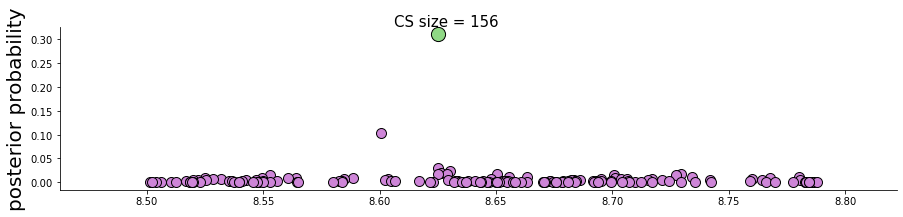

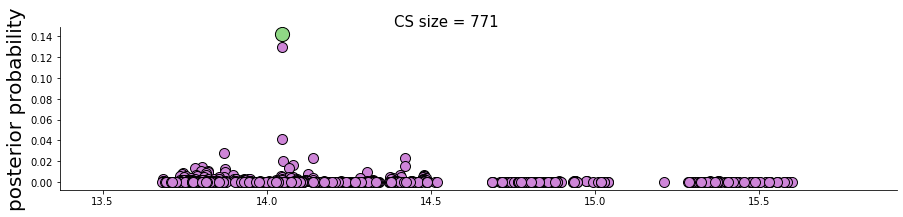

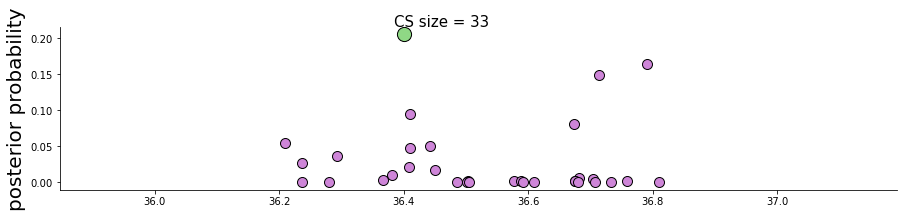

In [11]:
df_cs_list=[]
df_regions = []
for peak_snp in df_ld_block.index:
    
    target_trait = df_ld_block.loc[peak_snp]['trait']
    if target_trait =='PCCI':
        next
    else:
        df_cred = credible_snp_set(target_trait, peak_snp)
        df_temp = file_prep(target_trait, peak_snp)
        df_cs = pd.concat((df_cred.set_index('cred1'), df_temp),axis=1).dropna()
        df_cs['index_snp'] = peak_snp
        df_cs['trait'] = target_trait
        df_cs_list.append(df_cs)


        df_vep_input = df_cs.loc[:,['Chr', 'bp', 'A1','A2']]
        df_vep_input['allele'] = df_vep_input['A1']+'/'+df_vep_input['A2']
        df_vep_input['bp_2'] = df_vep_input['bp']
        df_vep_input = df_vep_input.loc[:,['Chr', 'bp', 'bp_2','allele']]

        filename = target_trait+'_'+peak_snp.replace(":", "_")

        df_vep_input.to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Candidate_gene_prioritization/VEP/'+\
                           filename+'_vep_input.txt', sep = '\t', index=False, header=False)


        for snp in df_vep_input['bp']:
            df_region = df_cPADRE_all_stage.loc[df_cPADRE_all_stage[0]=='chr'+str(df_vep_input['Chr'][0])]
            df_region = df_region.loc[(df_region[1]<=snp)&(df_region[2]>=snp)]
            if df_region.shape[0]>0:
                df_region['cred_snp'] = snp
                df_region['trait'] = target_trait
                df_region['index_snp'] = peak_snp
                df_regions.append(df_region)
df_region_snp = pd.concat(df_regions)
df_cs_all = pd.concat(df_cs_list)


In [594]:
df_cs_all.to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Credit_set_snp/credible_set.csv', 
                 sep = " ")

In [596]:
df_cs_all.loc[df_cs_all['bp'] == 36210206]

index     prob1    position  -log10_P  Chr        bp A1 A2  \
17:36210206    6.0  0.053861  36210206.0  9.153112   17  36210206  T  C   

                 Freq         b        se             p    index_snp    trait  
17:36210206  0.373733  0.135238  0.021935  7.028910e-10  17:36400200  T4_LDCI

In [12]:
df_region_snp

0         1         2            3     4  5         6         7  \
116553   chr2  44947922  44948514  3_TssFlank1  1000  .  44947922  44948514   
116553   chr2  44947922  44948514     9_ReprPC  1000  .  44947922  44948514   
116553   chr2  44947922  44948514       8_Pois  1000  .  44947922  44948514   
116553   chr2  44947922  44948514     7_EnhWk1  1000  .  44947922  44948514   
116553   chr2  44947922  44948514       8_Pois  1000  .  44947922  44948514   
...       ...       ...       ...          ...   ... ..       ...       ...   
3817    chr17  36587867  36590036       8_Pois  1000  .  36587867  36590036   
3817    chr17  36587867  36590036       8_Pois  1000  .  36587867  36590036   
3817    chr17  36587867  36590036      2_TssA2  1000  .  36587867  36590036   
3817    chr17  36587867  36590036  3_TssFlank1  1000  .  36587867  36590036   
3817    chr17  36587867  36590036       8_Pois  1000  .  36587867  36590036   

                  8    stage  cred_snp    trait    index_snp  
116553    51,160,44    Epi75  44948288     LDCI   2:44880680  
116553  202,178,214     dome  44948288     LDCI   2:44880680  
116553   106,61,154  longPec  44948288     LDCI   2:44880680  
116553    255,127,0    prim5  44948288     LDCI   2:44880680  
116553   106,61,154    Hpf12  44948288     LDCI   2:44880680  
...             ...      ...       ...      ...          ...  
3817     106,61,154    Epi75  36588580  T4_LDCI  17:36400200  
3817     106,61,154     dome  36588580  T4_LDCI  17:36400200  
3817     31,120,180  longPec  36588580  T4_LDCI  17:36400200  
3817      51,160,44    prim5  36588580  T4_LDCI  17:36400200  
3817     106,61,154    Hpf12  36588580  T4_LDCI  17:36400200  

[635 rows x 13 columns]

In [293]:
df_region_snp.loc[df_region_snp[3].isin(['1_TssA1','2_TssA1'])].sort_values(by=[0,1]).head(20)

0         1         2        3    stage  cred_snp  trait  \
126909  chr14  11762260  11763726  1_TssA1  longPec  11763424    DZE   
126909  chr14  11762260  11763726  1_TssA1    prim5  11763424    DZE   
126909  chr14  11762260  11763726  1_TssA1  longPec  11762328    DZE   
126909  chr14  11762260  11763726  1_TssA1    prim5  11762328    DZE   
126909  chr14  11762260  11763726  1_TssA1  longPec  11763314    DZE   
126909  chr14  11762260  11763726  1_TssA1    prim5  11763314    DZE   
116517   chr2  44615046  44616648  1_TssA1    Epi75  44616399   LDCI   
116517   chr2  44615046  44616648  1_TssA1     dome  44616399   LDCI   
116517   chr2  44615046  44616648  1_TssA1  longPec  44616399   LDCI   
116517   chr2  44615046  44616648  1_TssA1    prim5  44616399   LDCI   
116517   chr2  44615046  44616648  1_TssA1    Hpf12  44616399   LDCI   
116517   chr2  44615046  44616648  1_TssA1    Epi75  44616399  DZEAD   
116517   chr2  44615046  44616648  1_TssA1     dome  44616399  DZEAD   
116517   chr2  44615046  44616648  1_TssA1  longPec  44616399  DZEAD   
116517   chr2  44615046  44616648  1_TssA1    prim5  44616399  DZEAD   
116517   chr2  44615046  44616648  1_TssA1    Hpf12  44616399  DZEAD   
116527   chr2  44745746  44747801  1_TssA1    Epi75  44747060   LDCI   
116527   chr2  44745746  44747801  1_TssA1     dome  44747060   LDCI   
116527   chr2  44745746  44747801  1_TssA1  longPec  44747060   LDCI   
116527   chr2  44745746  44747801  1_TssA1    Hpf12  44747060   LDCI   

          index_snp  
126909  14:11581401  
126909  14:11581401  
126909  14:11581401  
126909  14:11581401  
126909  14:11581401  
126909  14:11581401  
116517   2:44880680  
116517   2:44880680  
116517   2:44880680  
116517   2:44880680  
116517   2:44880680  
116517   2:45038809  
116517   2:45038809  
116517   2:45038809  
116517   2:45038809  
116517   2:45038809  
116527   2:44880680  
116527   2:44880680  
116527   2:44880680  
116527   2:44880680

In [536]:
df_ld_block.index

Index(['2:44880680', '5:3117060', '14:46314911', '17:33116150', '11:29830387',
       '14:22461182', '23:34096507', '5:66958636', '14:11581401',
       '17:13723952', '2:45038809', '5:12451112', '5:66959339', '23:8624915',
       '20:14046054', '17:36400200'],
      dtype='object', name='Peak_SNP')

In [16]:
df_region_snp.loc[(df_region_snp[3].str.contains('5_'))&(df_region_snp['index_snp']=='17:36400200')].drop_duplicates(['cred_snp'])


0         1         2        3     4  5         6         7  \
3791  chr17  36209698  36210236  5_EnhA1  1000  .  36209698  36210236   

              8    stage  cred_snp    trait    index_snp  
3791  227,26,28  longPec  36210206  T4_LDCI  17:36400200

In [620]:
df_region_snp.loc[(df_region_snp[3]=='2_TssA2')&(df_region_snp['index_snp']=='17:36400200')].drop_duplicates(['cred_snp'])


0         1         2        3    stage  cred_snp    trait  \
3817  chr17  36587867  36590036  2_TssA2  longPec  36588580  T4_LDCI   

        index_snp  
3817  17:36400200

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


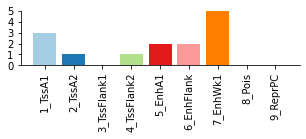

In [606]:
def func1(color_list):
    new_color=[]
    for i in color_list.split(","):
        new_color.append((int(i)/255))
    return new_color
df_color = df_cPADRE_all_stage.drop_duplicates([3,8])[[3,8]].set_index(3)
df_color[8] = df_color[8].apply(lambda x: func1(x))
dic_color = df_color[8].to_dict()
f,ax =plt.subplots(1,1, figsize = (5,1))
snp_num_list = []
for i, element in enumerate (sorted(df_region_snp[3].unique())[1:]):
    
    snp_num = df_region_snp.loc[(df_region_snp[3]==element)&(df_region_snp['index_snp']=='5:12451112')].drop_duplicates(['cred_snp']).shape[0]
    
    ax.bar(element, snp_num, color=dic_color[element])
ax.set_ylim(0,5)
ax.set_yticks([0,1,2,3,4,5])
ax.set_xticklabels(sorted(df_region_snp[3].unique())[1:], size=10, rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [446]:
df_ld = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Credit_set_snp/T4_LDCI_17_36400200.ld', 
                   sep =' ', index_col=None, header=None)
df_ld

0         1         2         3         4         5         6     \
0     1.000000  0.019481  0.801409  0.730362  0.707161  0.376035  0.375901   
1     0.019481  1.000000 -0.385862  0.202836  0.218986 -0.167276  0.631291   
2     0.801409 -0.385862  1.000000  0.444609  0.407651  0.464536 -0.240753   
3     0.730362  0.202836  0.444609  1.000000  0.963794  0.513622  0.506712   
4     0.707161  0.218986  0.407651  0.963794  1.000000  0.531110  0.525705   
...        ...       ...       ...       ...       ...       ...       ...   
4785 -0.280280  0.602889 -0.214743 -0.159333 -0.152153 -0.004428 -0.123686   
4786  0.748466  0.042069  0.539624  0.475999  0.483618  0.286259  0.385941   
4787 -0.544866 -0.463977 -0.383982 -0.359801 -0.372368 -0.280412 -0.295515   
4788  0.483669 -0.262641  0.608125 -0.121564 -0.102830 -0.149509 -0.154426   
4789  0.355473  0.576143  0.140225  0.065205  0.100060 -0.186190  0.366153   

          7         8         9     ...      4781      4782      4783  \
0     0.313139  0.448987  0.531983  ...  0.255500 -0.116308  0.251840   
1     0.687489 -0.192543  0.077606  ...  0.103847 -0.212735  0.525536   
2     0.043292  0.551110  0.759613  ... -0.002391 -0.038434 -0.279942   
3    -0.047940  0.611952  0.271427  ...  0.535590 -0.004171  0.394603   
4    -0.021884  0.633551  0.239119  ...  0.505779 -0.032555  0.417844   
...        ...       ...       ...  ...       ...       ...       ...   
4785  0.433649 -0.047799  0.418408  ... -0.295545 -0.170392 -0.128538   
4786  0.331008  0.364620  0.297410  ...  0.271668 -0.389866  0.446624   
4787 -0.631550 -0.327613 -0.587681  ... -0.062095  0.505244 -0.352211   
4788  0.377581  0.068812  0.443606  ... -0.397035 -0.203945 -0.193884   
4789  0.827544 -0.064043  0.412709  ... -0.175621 -0.380968  0.431134   

          4784      4785      4786      4787      4788      4789  4790  
0    -0.008235 -0.280280  0.748466 -0.544866  0.483669  0.355473   NaN  
1     0.350636  0.602889  0.042069 -0.463977 -0.262641  0.576143   NaN  
2     0.104266 -0.214743  0.539624 -0.383982  0.608125  0.140225   NaN  
3     0.204737 -0.159333  0.475999 -0.359801 -0.121564  0.065205   NaN  
4     0.185519 -0.152153  0.483618 -0.372368 -0.102830  0.100060   NaN  
...        ...       ...       ...       ...       ...       ...   ...  
4785  0.684215  1.000000 -0.339989 -0.363933 -0.210971  0.456110   NaN  
4786  0.052492 -0.339989  1.000000 -0.752024  0.512247  0.466877   NaN  
4787 -0.531336 -0.363933 -0.752024  1.000000 -0.359429 -0.782224   NaN  
4788 -0.303558 -0.210971  0.512247 -0.359429  1.000000  0.483713   NaN  
4789  0.119446  0.456110  0.466877 -0.782224  0.483713  1.000000   NaN  

[4790 rows x 4791 columns]

In [492]:
df_cs_snp = pd.read_csv("/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Credit_set_snp/T4_LDCI_17_36400200.snp",
                       sep = " ")
cs_snp_index = df_cs_snp.loc[df_cs_snp['rsid'].isin(df_cred['cred1'])]['index']

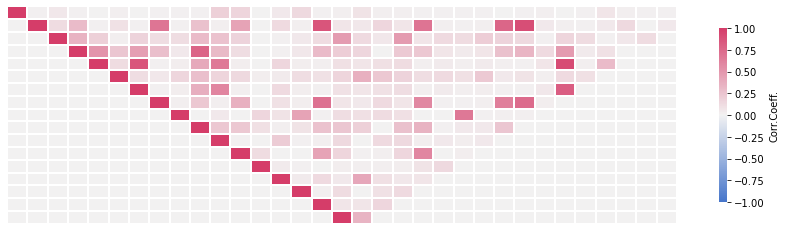

In [510]:
df_ld_test = df_ld.loc[cs_snp_index, cs_snp_index].copy()

cutoff = round(df_ld_test.shape[0]/2)
for i in range(df_ld_test.shape[0]):
    if i>cutoff:
        for j in range(df_ld_test.shape[1]):
            df_ld_test.iloc[i,j]=0
    else:
        for j in range(df_ld_test.shape[1]):
            if j<=cutoff and i>j:
                df_ld_test.iloc[i,j]=0
            elif j>=cutoff and i<j and i>2*cutoff-j+1:
                df_ld_test.iloc[i,j]=0
f, ax=plt.subplots(figsize=(15,4))
df_plot = df_ld_test*df_ld_test
df_plot = df_plot.iloc[:cutoff+1,:]
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(df_plot.round(2), cmap=cmap, vmax=1, vmin=-1, center=0,
            square=False, linewidths=.2, cbar_kws={"shrink": 0.8,'label':'Corr.Coeff.'}, \
            annot=None,annot_kws={'fontsize':12}, ax=ax)
ax.set_xticklabels('')
plt.tick_params(
                    axis='both', 
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are on
                    top=False,         # ticks along the top edge are off
                    left=False,
                    labelbottom=False,
                    labelleft=False)
plt.show()